In [5]:
#import typing
#import io
#import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

import cv2

NameError: name '_C' is not defined

In [ ]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py
#https://pythonawesome.com/explainability-for-vision-transformers-in-pytorch/
#https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/Transformer_MM_explainability_ViT.ipynb
#https://jacobgil.github.io/deeplearning/vision-transformer-explainability#gradient-attention-rollout-for-class-specific-explainability
#https://arxiv.org/pdf/2012.09838v1.pdf

In [6]:

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
checkpoint = torch.load("output/test_checkpoint.pth")  # Load the checkpoint
model.load_state_dict(checkpoint['state_dict'])
model.eval()

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("augmented_data_test/img8504_flip_rescale_augmented.jpg")
x = transform(im)
x.size()

NameError: name 'CONFIGS' is not defined

In [ ]:
#https://github.com/hila-chefer/Transformer-Explainability/blob/main/Transformer_explainability.ipynb

from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

#normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = 197 * 768 # model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens)
    for blk in model(input.unsqueeze(0))[1]:
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
checkpoint = torch.load("output/test_checkpoint.pth")  # Load the checkpoint
model.load_state_dict(checkpoint['state_dict'])
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

generate_visualization(x)
     

Input tensor size: torch.Size([1, 197, 768])
tensor([[42.8359, 34.3111, 42.7188, 37.1442, 42.9958, 39.6628, 43.1217, 39.0116,
         41.6461, 38.5255, 41.6031, 40.2355, 41.8666, 41.5788, 42.4540, 41.3198,
         42.4015, 40.2889, 42.5653, 42.1829, 42.7174, 43.6092, 42.8724, 43.8819]],
       grad_fn=<AddmmBackward0>)


AttributeError: 'VisionTransformer' object has no attribute 'relprop'

In [ ]:
model(x.unsqueeze(0))[1]

Input tensor size: torch.Size([1, 197, 768])


[tensor([[[[9.2404e-01, 6.2079e-04, 5.3646e-04,  ..., 4.8016e-04,
            5.1420e-04, 5.9551e-04],
           [9.5549e-01, 3.7273e-04, 3.4380e-04,  ..., 2.7144e-04,
            2.8310e-04, 3.0910e-04],
           [9.5448e-01, 3.5945e-04, 3.6691e-04,  ..., 2.9468e-04,
            3.0194e-04, 3.0359e-04],
           ...,
           [9.4991e-01, 2.7363e-04, 2.8508e-04,  ..., 4.4283e-04,
            4.5083e-04, 4.4779e-04],
           [9.5051e-01, 2.7476e-04, 2.8169e-04,  ..., 4.2938e-04,
            4.6011e-04, 4.6728e-04],
           [9.5007e-01, 2.8579e-04, 2.7001e-04,  ..., 4.0810e-04,
            4.4668e-04, 4.8984e-04]],
 
          [[9.8137e-01, 1.0263e-04, 9.8734e-05,  ..., 8.7593e-05,
            8.7050e-05, 8.8003e-05],
           [1.2524e-01, 6.0954e-03, 7.0725e-03,  ..., 6.3608e-03,
            6.4603e-03, 5.3950e-03],
           [1.2626e-01, 6.5687e-03, 6.6658e-03,  ..., 6.0285e-03,
            6.1393e-03, 5.8240e-03],
           ...,
           [1.4185e-01, 6.3895e-03, 6.

In [ ]:
# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input)[0]
    if index == None:
        index = np.argmax(output.detach().numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = 197 * 768 # model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens)
    for blk in model(input)[1]:
        grad = blk.attn.get_attn_gradients()
        cam = blk # blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R, cam)
    return R[0, 1:]

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = generate_relevance(model, original_image.unsqueeze(0), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
checkpoint = torch.load("output/test_checkpoint.pth")  # Load the checkpoint
model.load_state_dict(checkpoint['state_dict'])
model.eval()

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
image = Image.open("augmented_data_test/img8504_flip_rescale_augmented.jpg")
x = transform(image)
x.size()


torch.Size([3, 224, 228])

In [ ]:
from vit_rollout import VITAttentionRollout

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
image = Image.open("augmented_data_test/img8504_flip_rescale_augmented.jpg")
x = transform(image)
x.size()

config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
grad_rollout = VITAttentionRollout(model, discard_ratio=0.0,  head_fusion = 'max')
mask = grad_rollout(x.unsqueeze(0), category_index=7)
np_img = np.array(image)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))




fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('Attention Map')
# Display the original image
ax1.imshow(image)
# Display the attention map as a heatmap
ax2.imshow(image)
cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
fig.colorbar(cax, ax=ax2, orientation='vertical', shrink=0.5)
plt.show()

TypeError: VITAttentionRollout.__call__() got an unexpected keyword argument 'category_index'

C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Input tensor size: torch.Size([1, 197, 768])


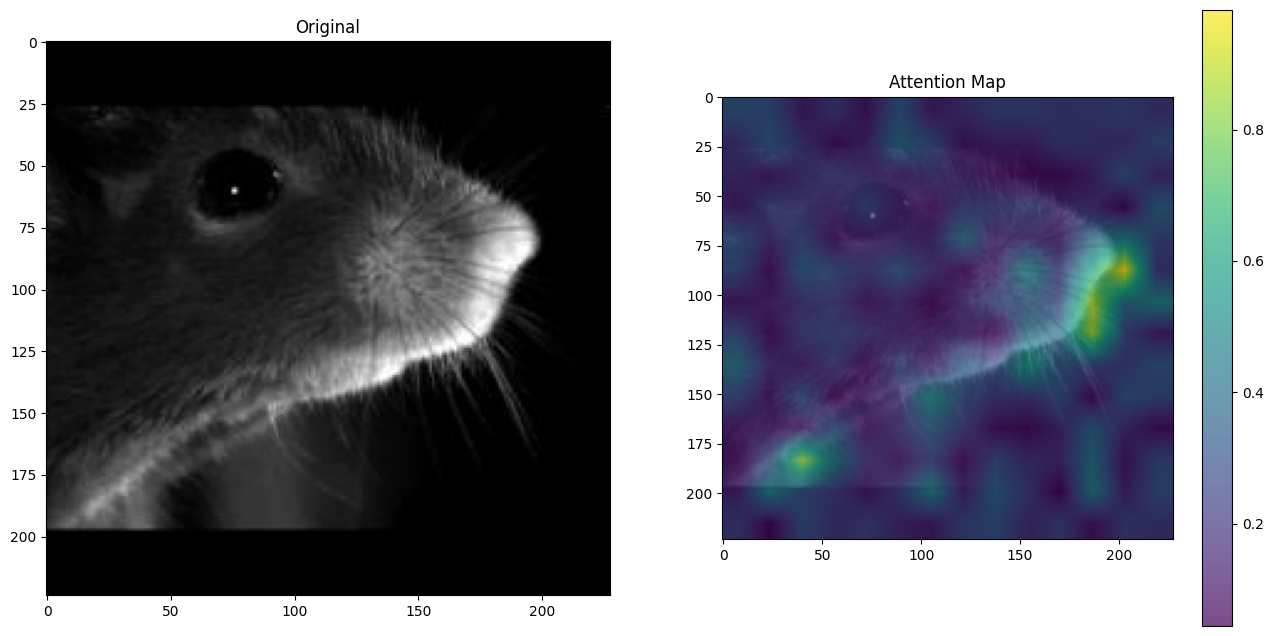

Input tensor size: torch.Size([1, 197, 768])


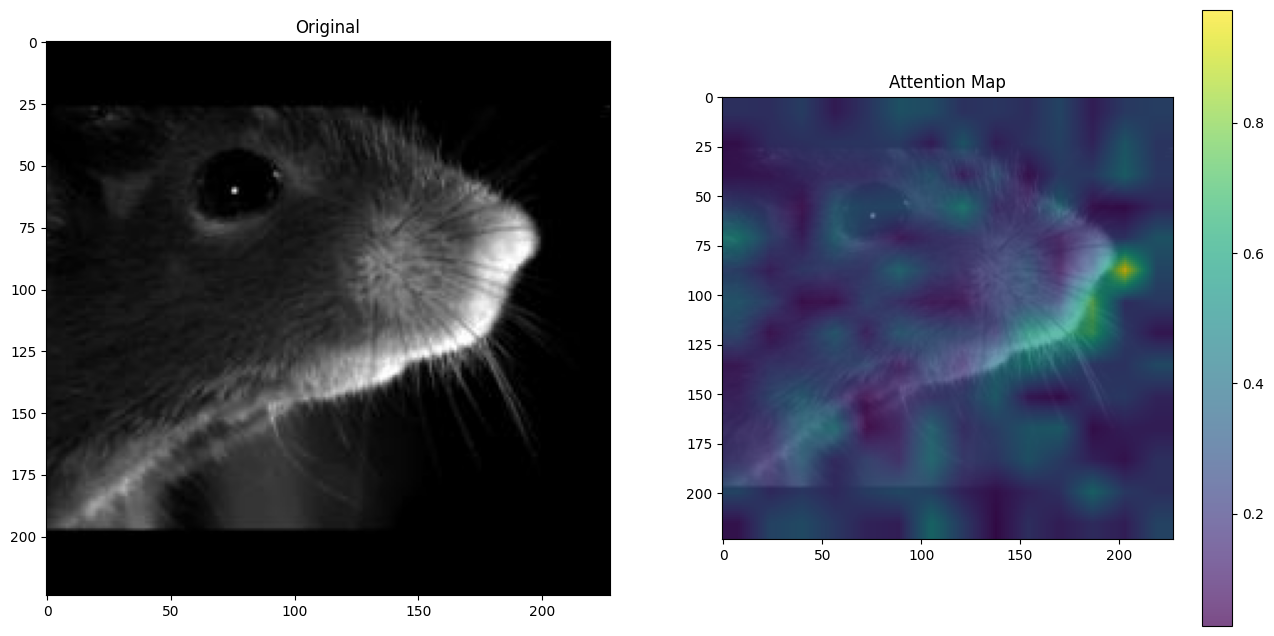

Input tensor size: torch.Size([1, 197, 768])


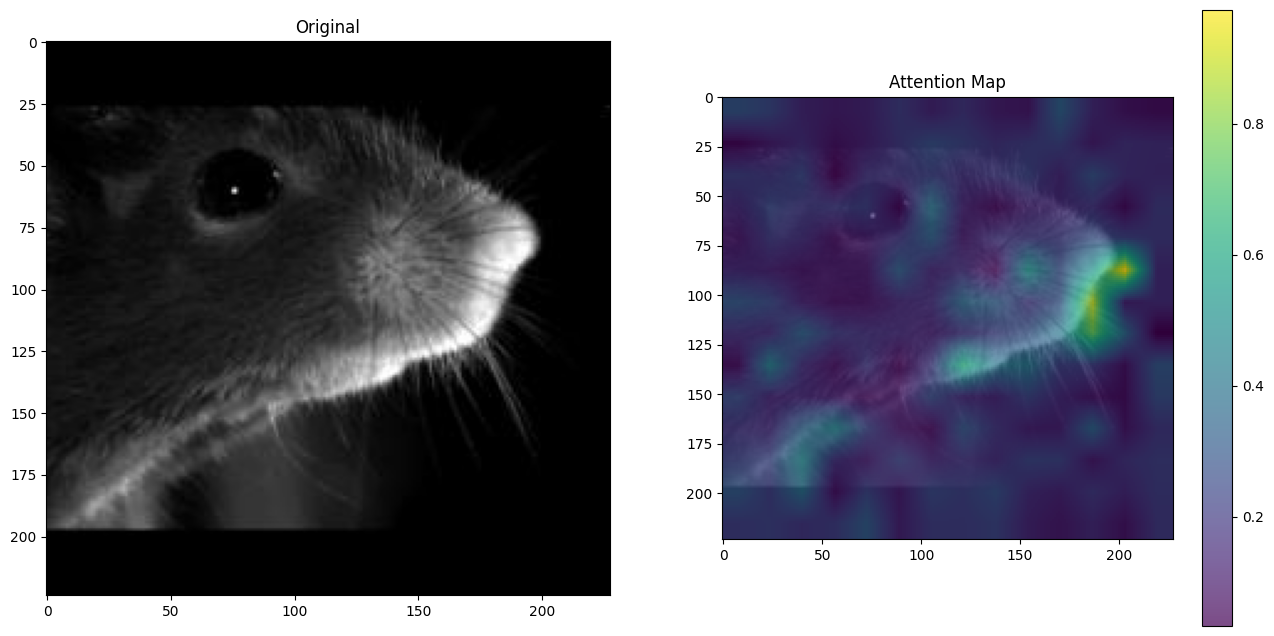

Input tensor size: torch.Size([1, 197, 768])


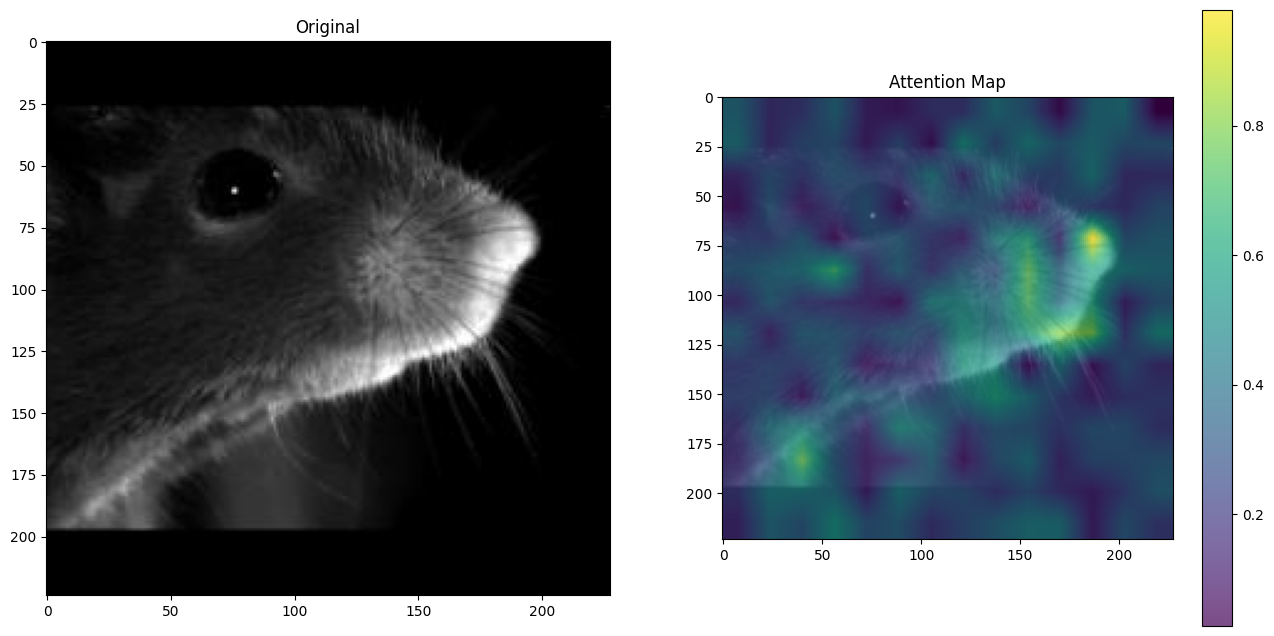

Input tensor size: torch.Size([1, 197, 768])


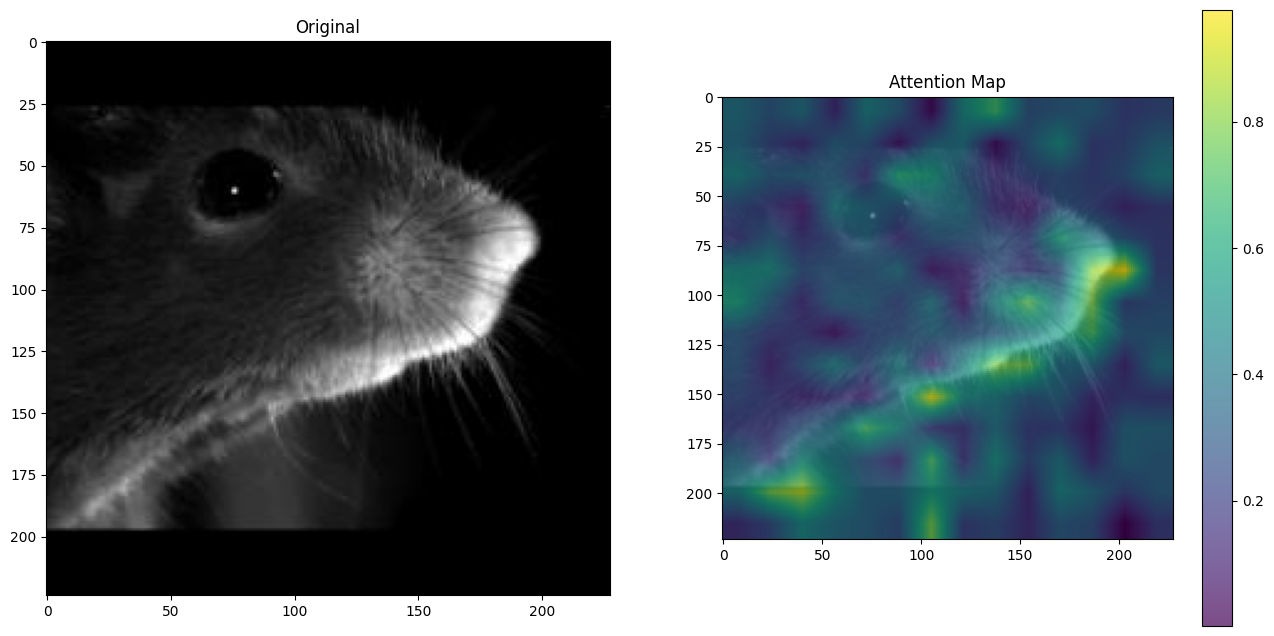

In [ ]:
from vit_grad_rollout import VITAttentionGradRollout

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
image = Image.open("augmented_data_test/img8504_flip_rescale_augmented.jpg")
x = transform(image)
x.size()

config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=24, zero_head=False, img_size=224, vis=True)
for i in [0.0,0.2,0.5,0.7,0.9]:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=i)
    mask = grad_rollout(x.unsqueeze(0), category_index=7)
    np_img = np.array(image)[:, :, ::-1]
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))




    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    # Display the original image
    ax1.imshow(image)
    # Display the attention map as a heatmap
    ax2.imshow(image)
    cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
    fig.colorbar(cax, ax=ax2, orientation='vertical', shrink=0.5)
    plt.show()


Input tensor size: torch.Size([1, 197, 768])


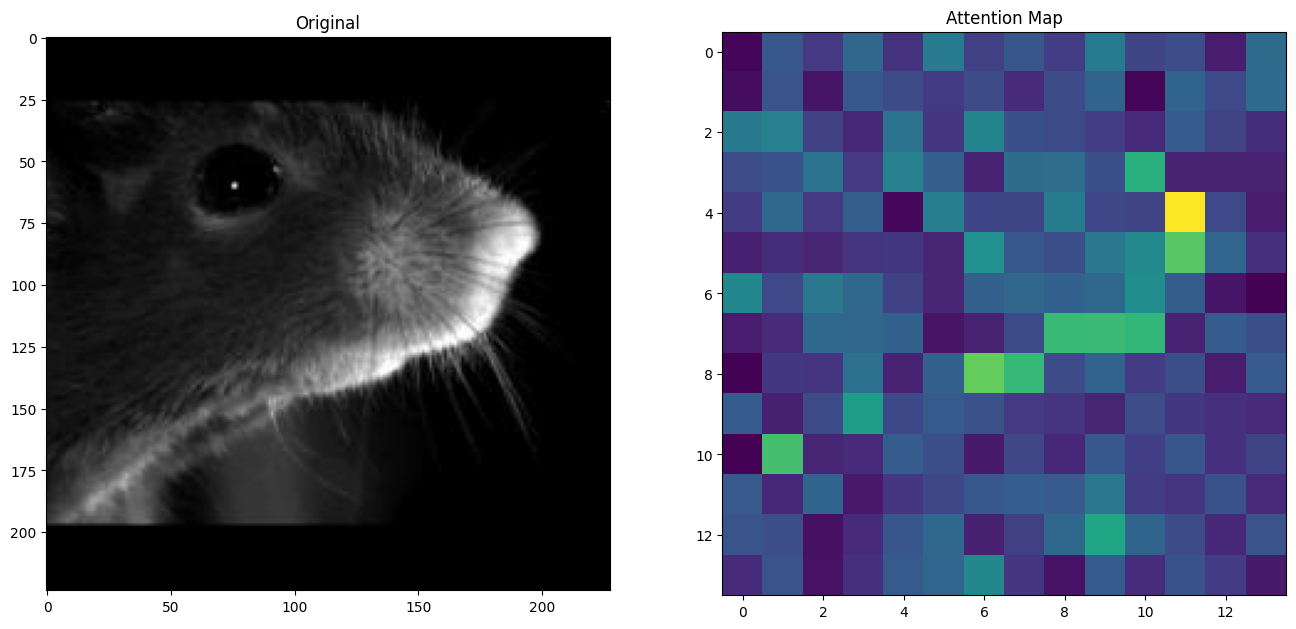

Input tensor size: torch.Size([1, 197, 768])


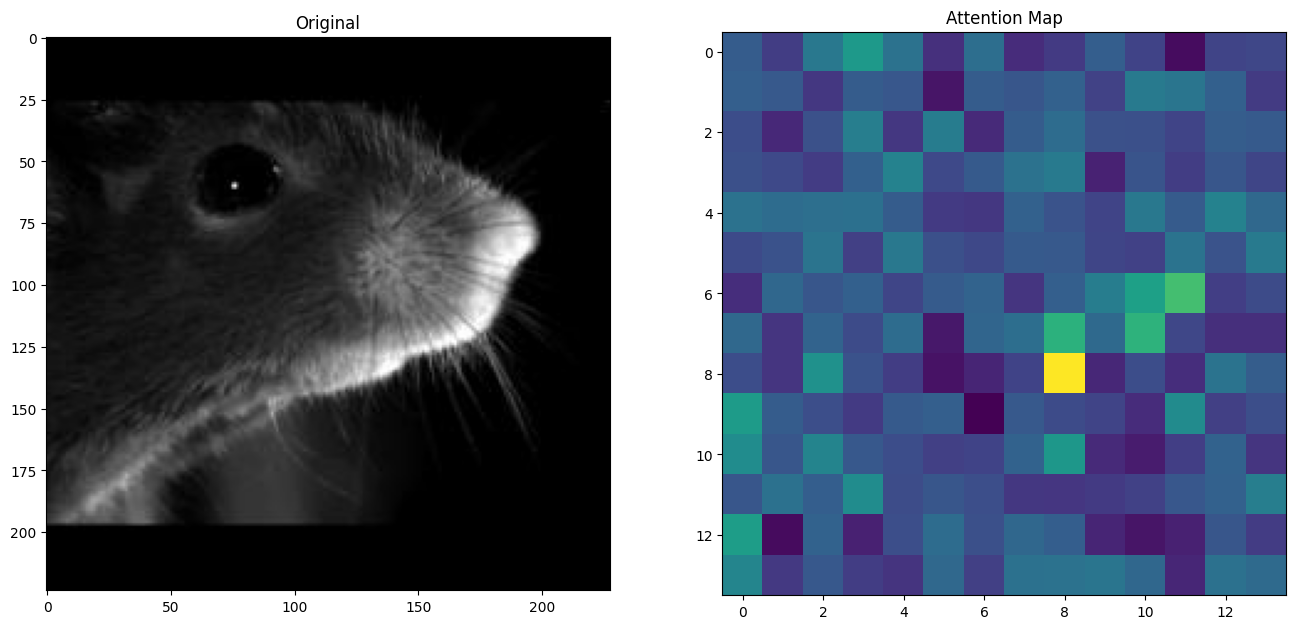

Input tensor size: torch.Size([1, 197, 768])


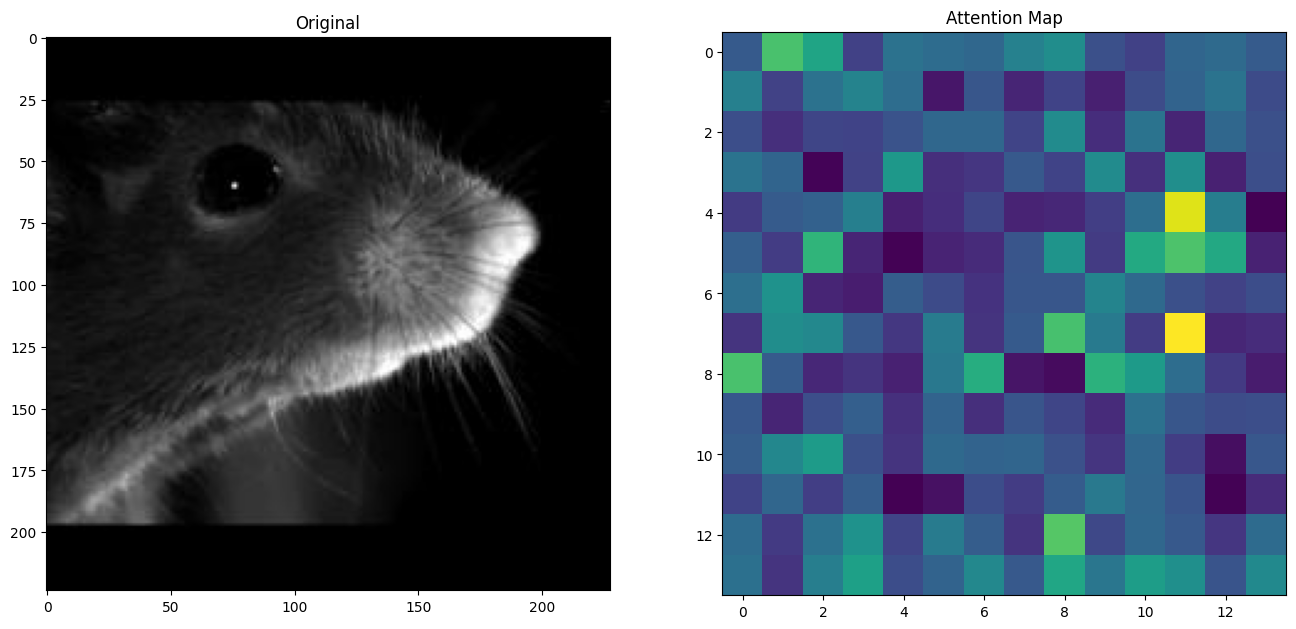

Input tensor size: torch.Size([1, 197, 768])


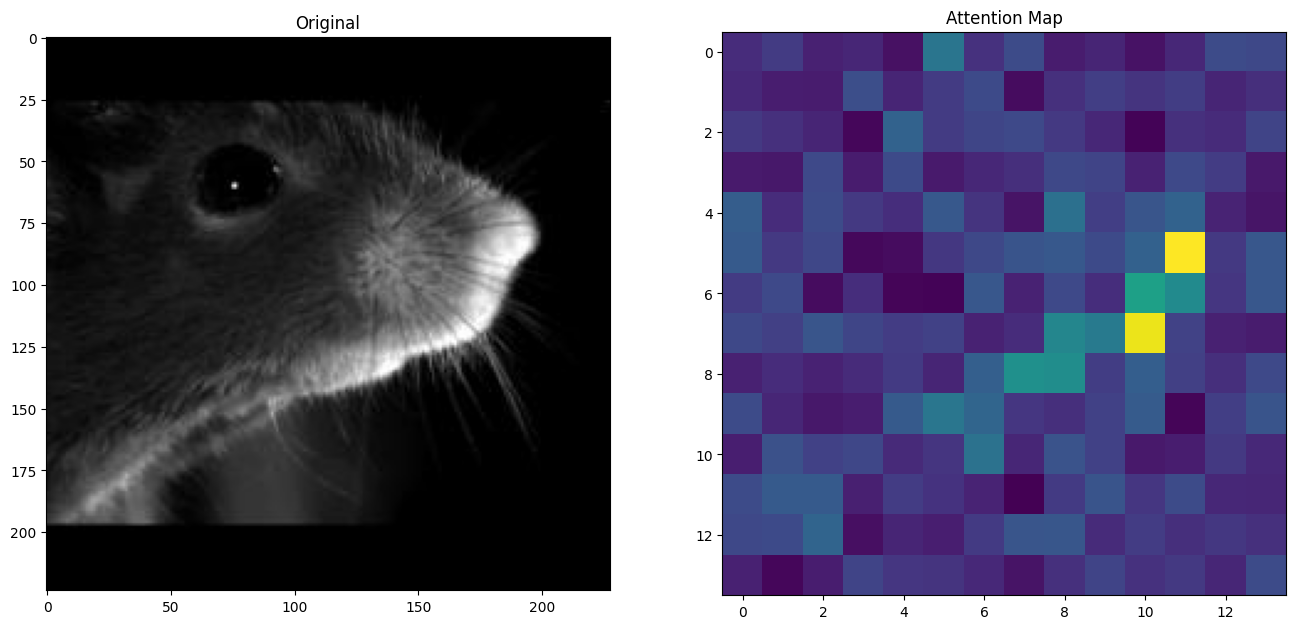

Input tensor size: torch.Size([1, 197, 768])


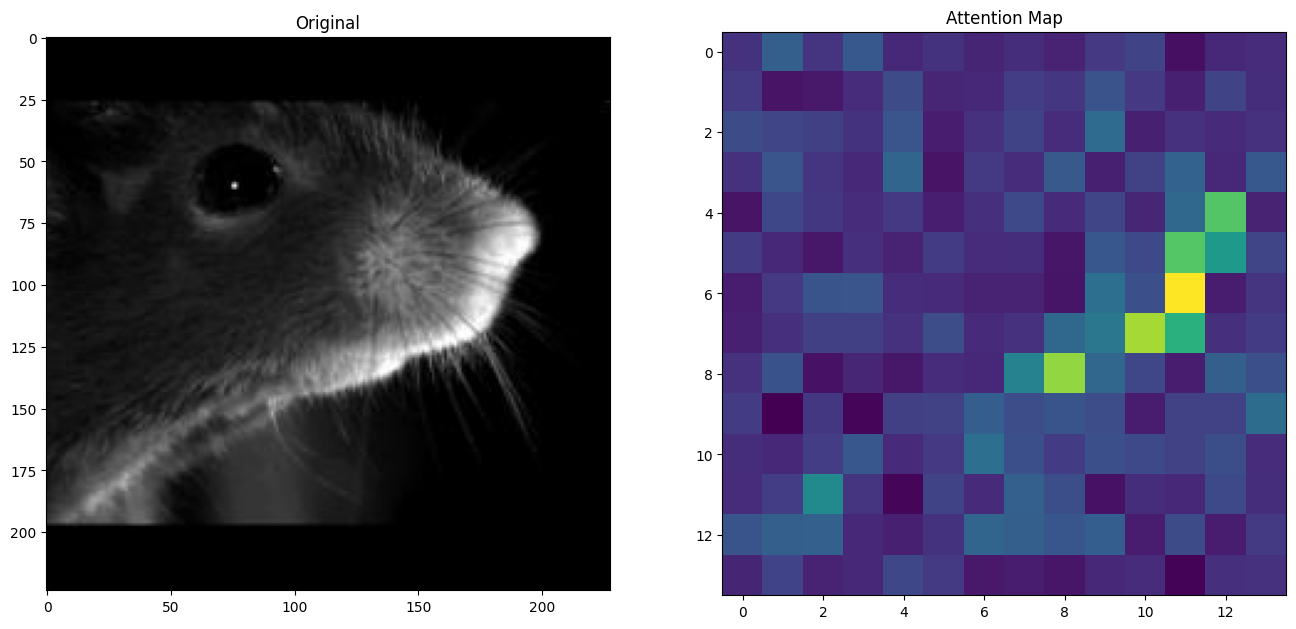

Input tensor size: torch.Size([1, 197, 768])


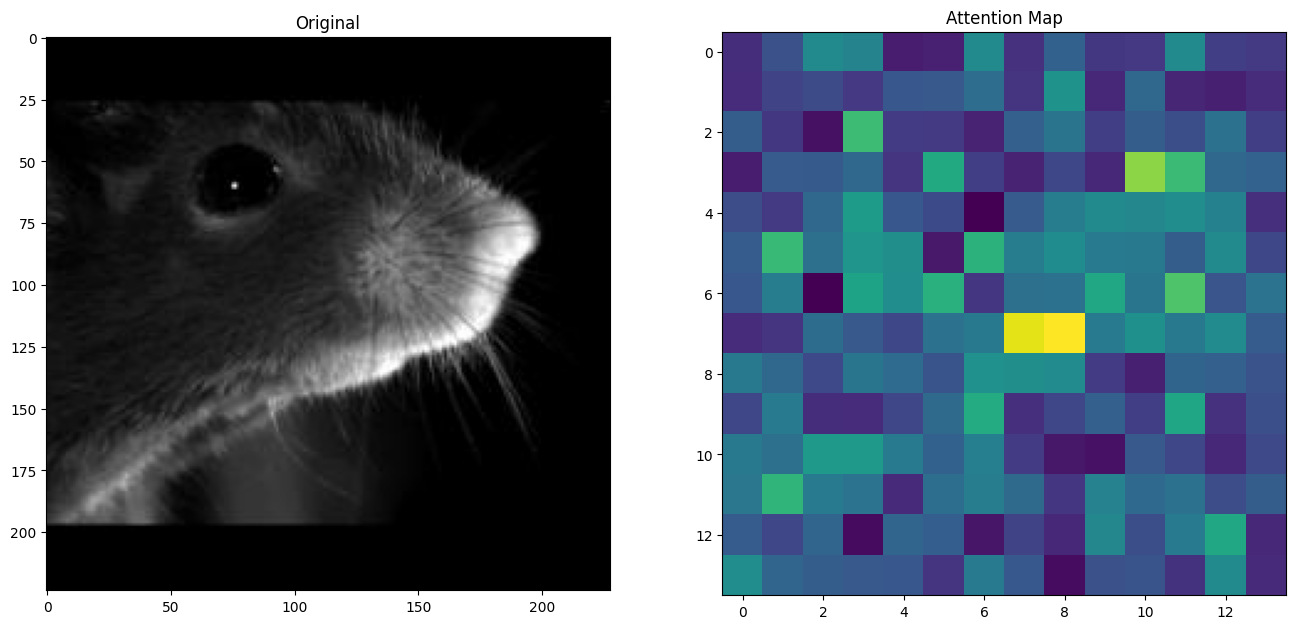

Input tensor size: torch.Size([1, 197, 768])


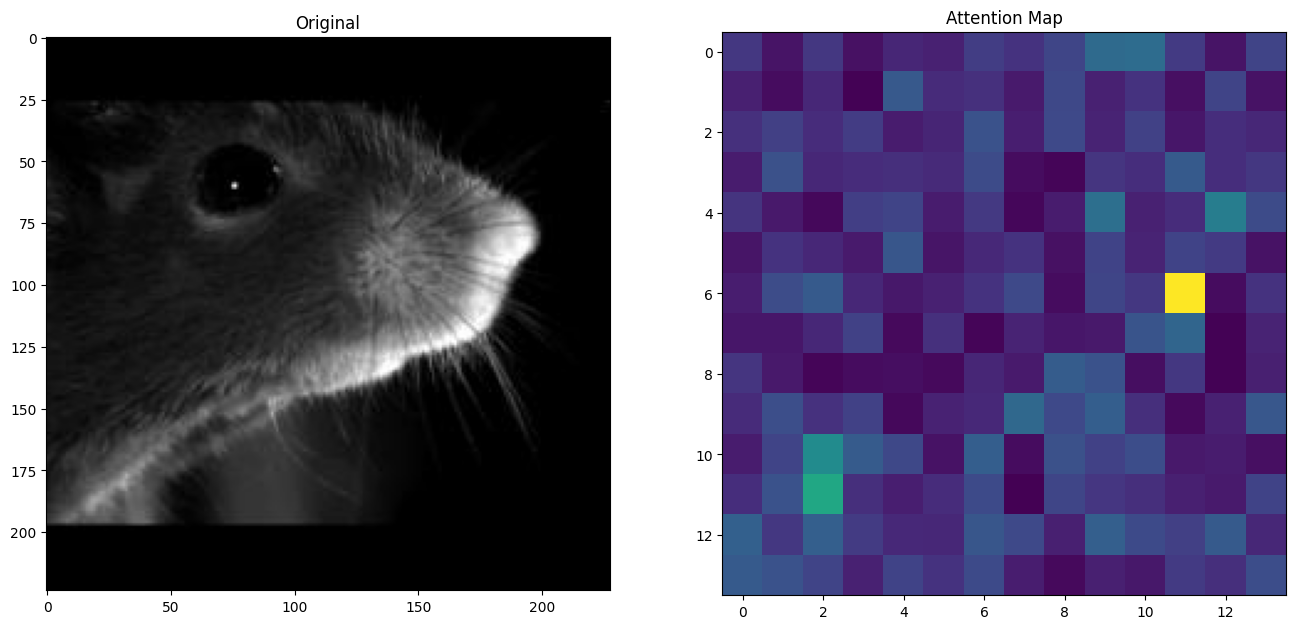

Input tensor size: torch.Size([1, 197, 768])


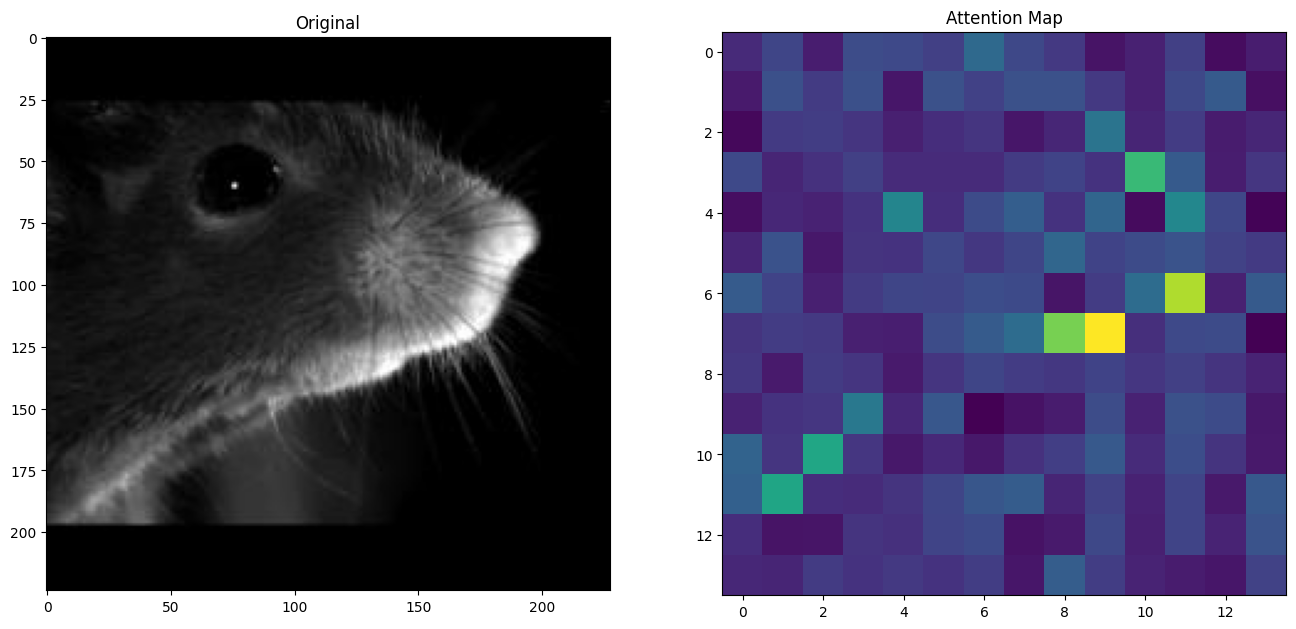

Input tensor size: torch.Size([1, 197, 768])


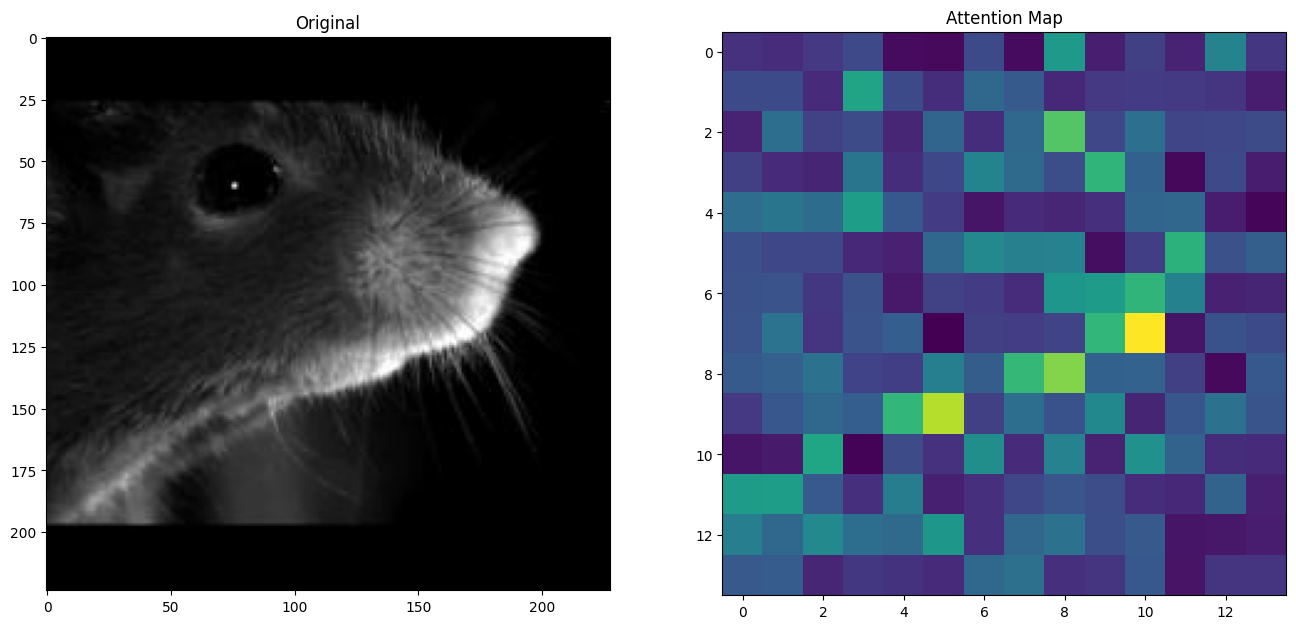

Input tensor size: torch.Size([1, 197, 768])


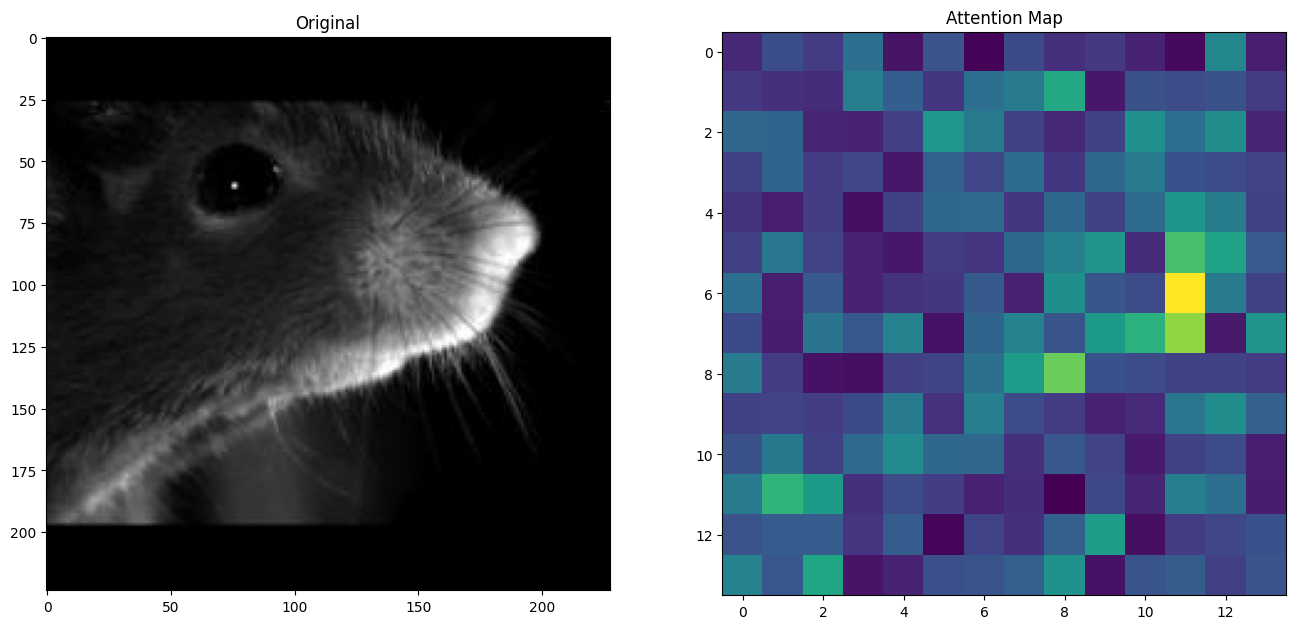

Input tensor size: torch.Size([1, 197, 768])


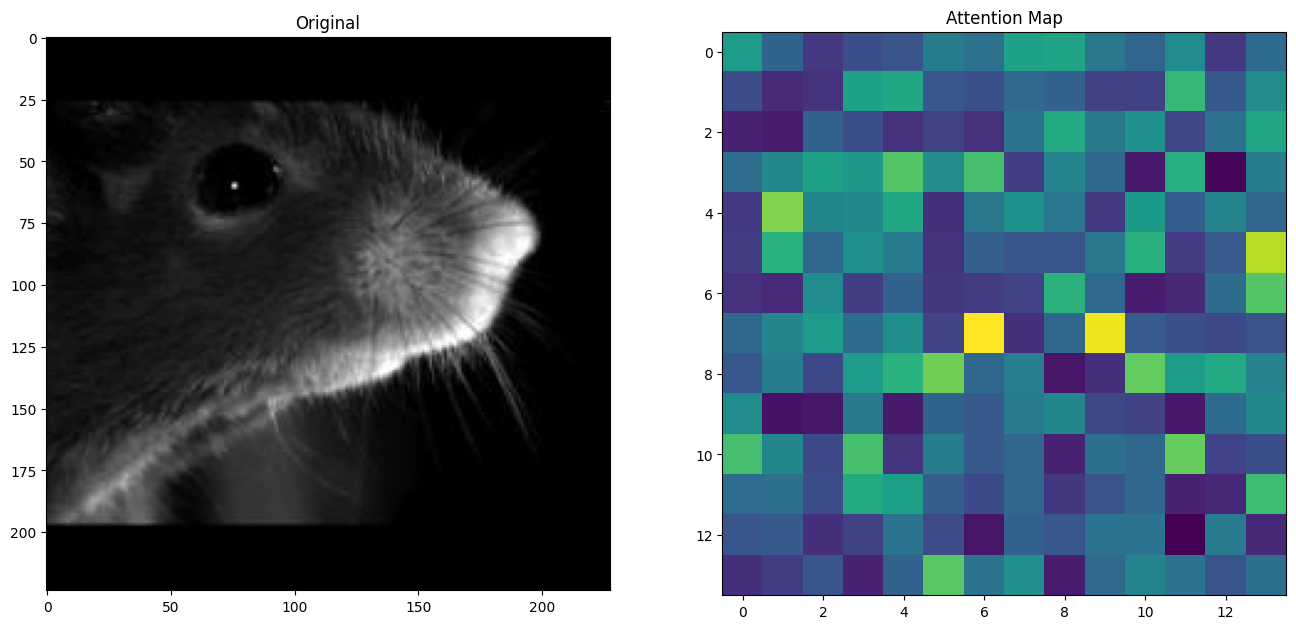

Input tensor size: torch.Size([1, 197, 768])


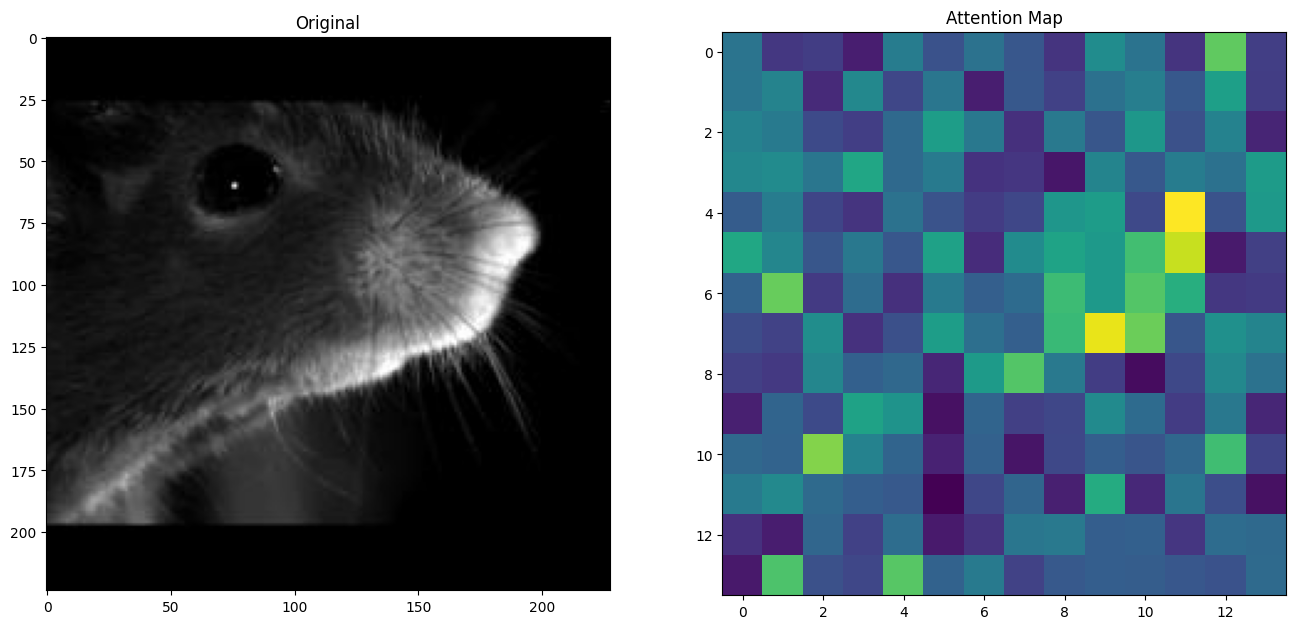

Input tensor size: torch.Size([1, 197, 768])


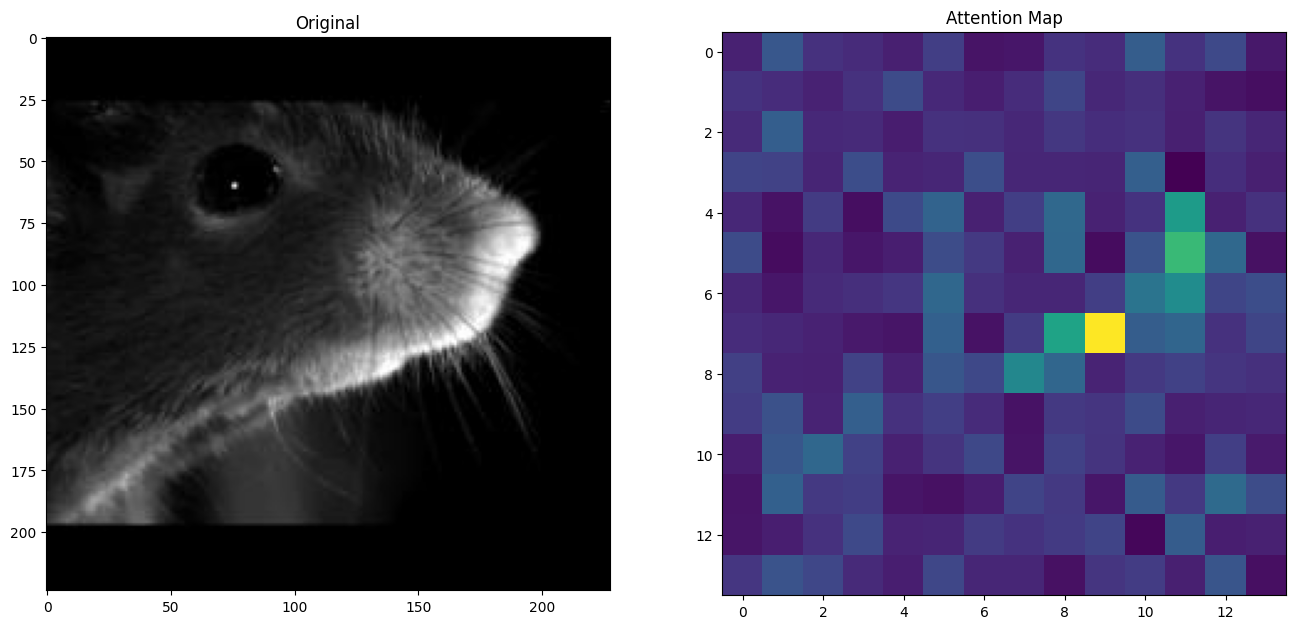

Input tensor size: torch.Size([1, 197, 768])


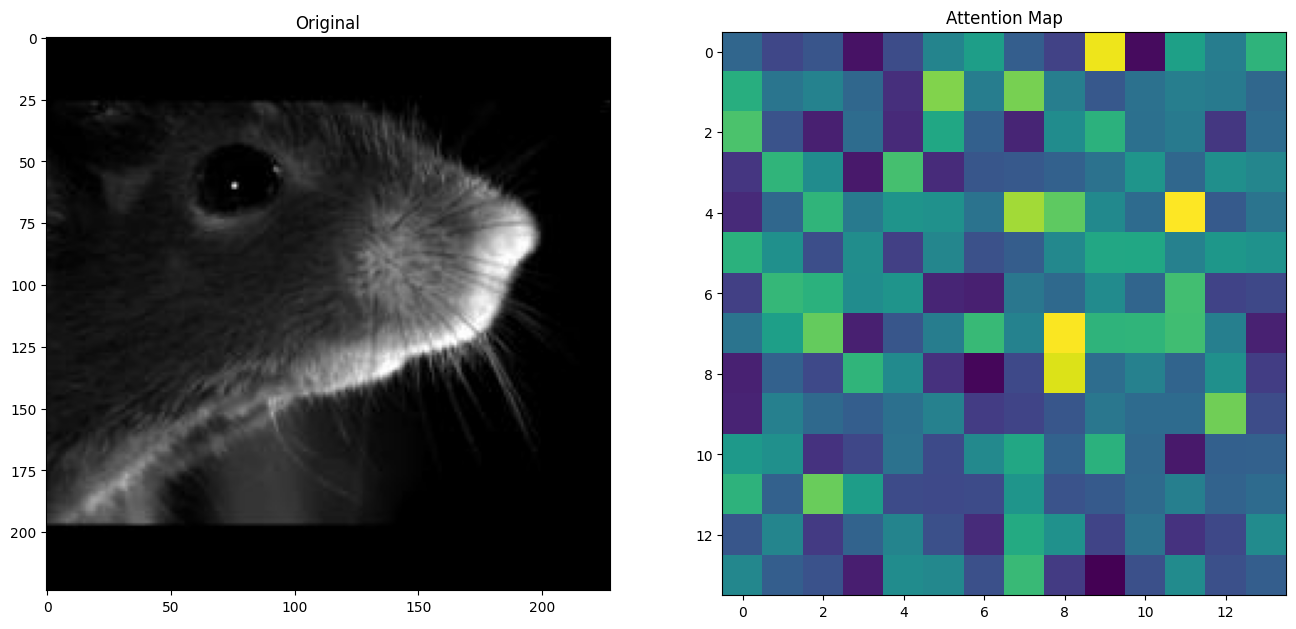

Input tensor size: torch.Size([1, 197, 768])


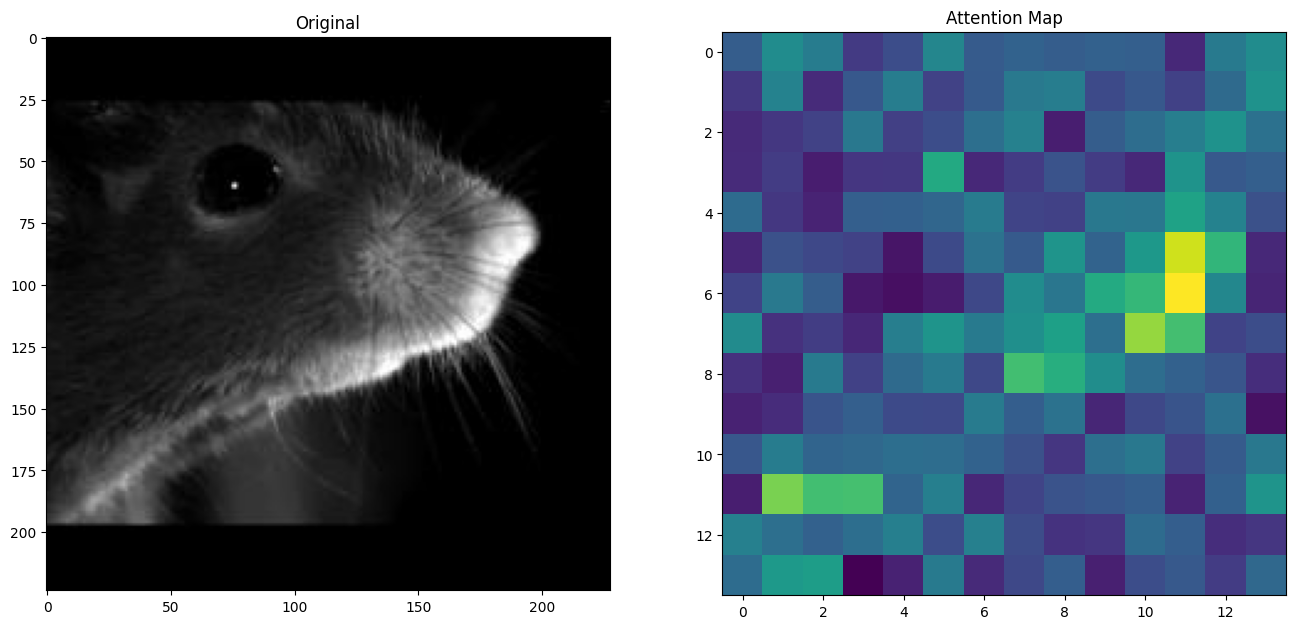

Input tensor size: torch.Size([1, 197, 768])


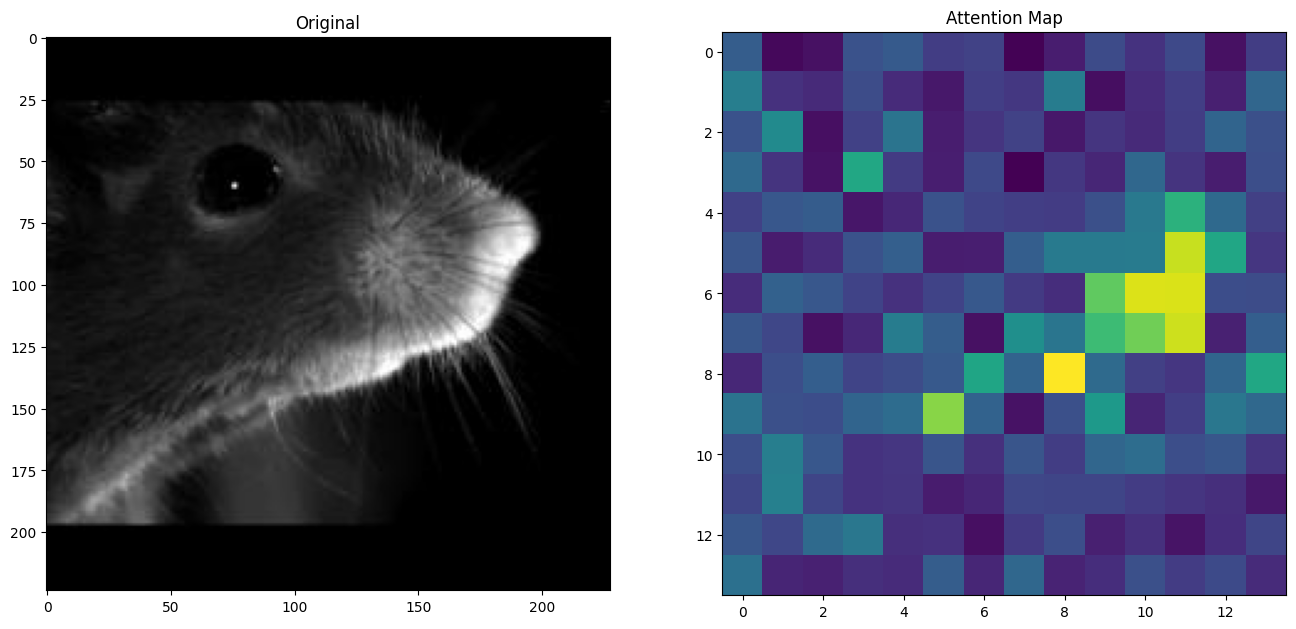

Input tensor size: torch.Size([1, 197, 768])


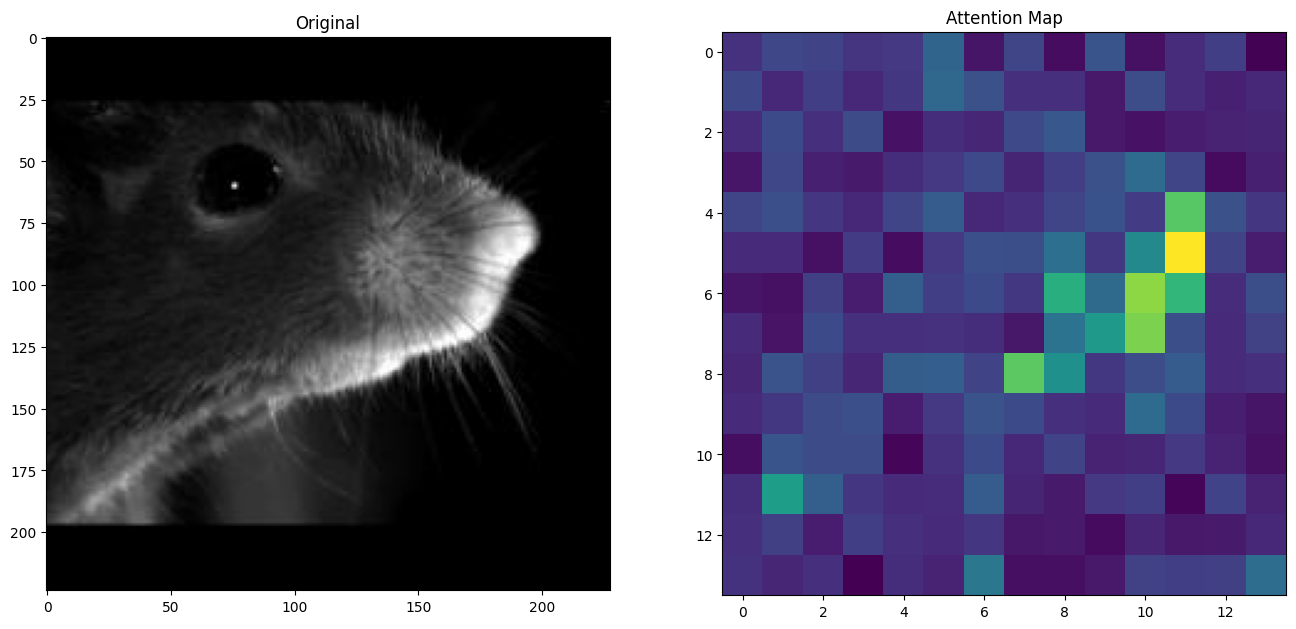

Input tensor size: torch.Size([1, 197, 768])


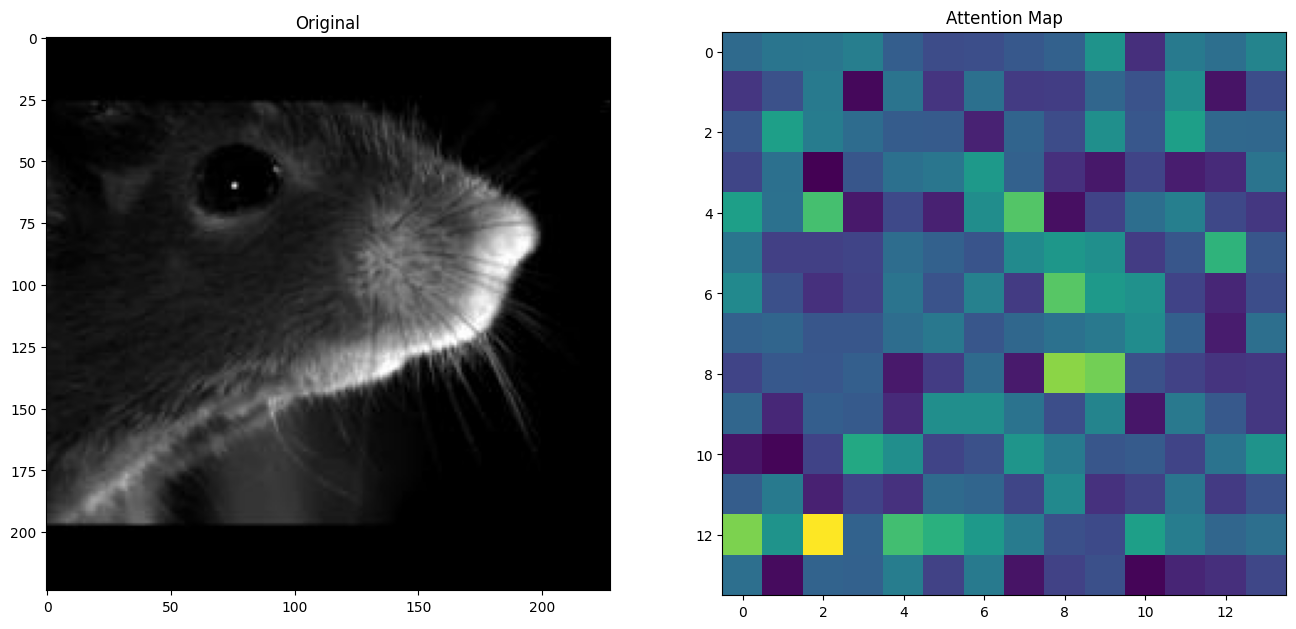

Input tensor size: torch.Size([1, 197, 768])


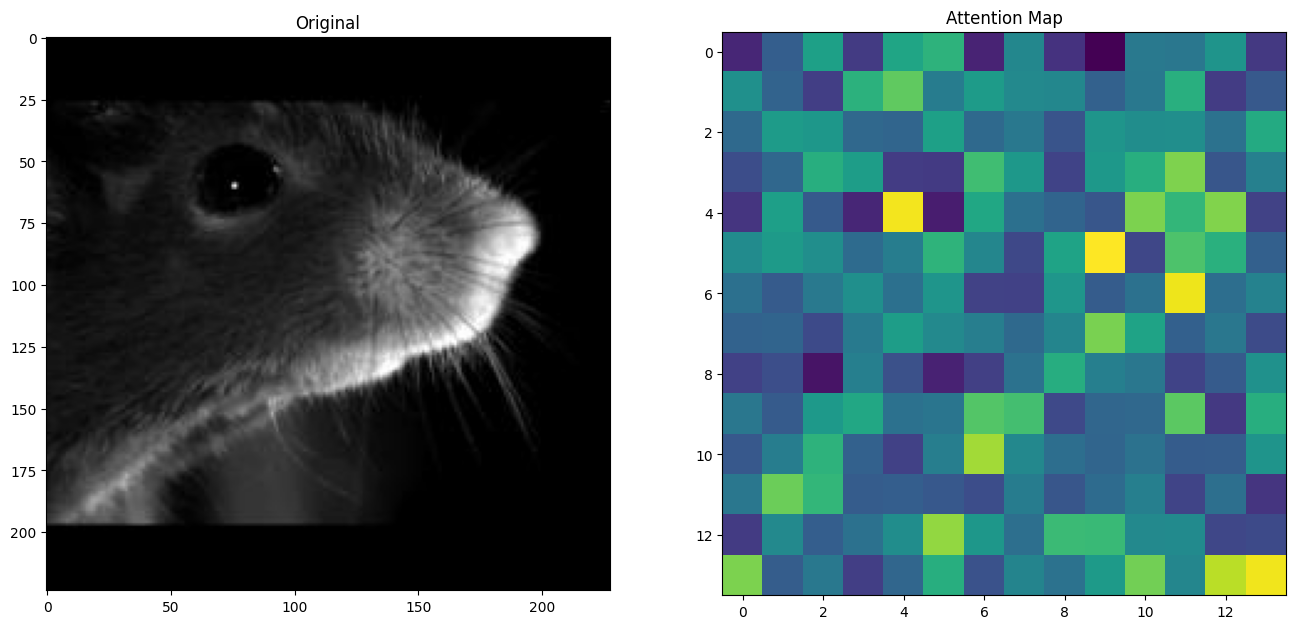

Input tensor size: torch.Size([1, 197, 768])


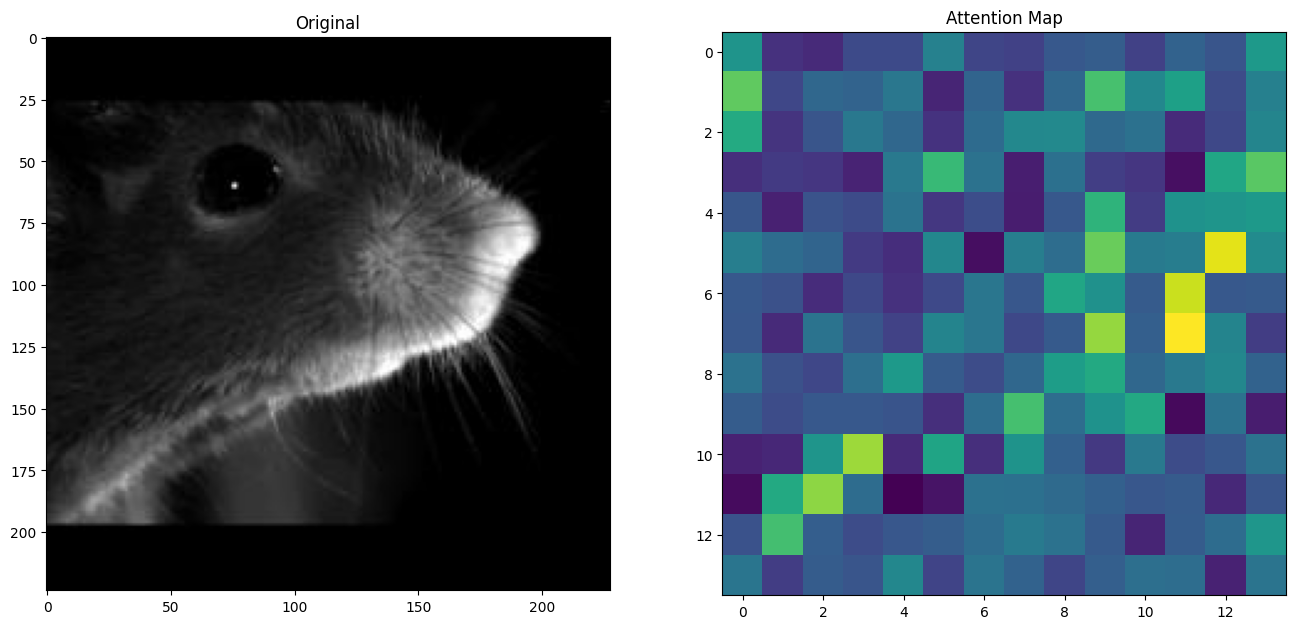

Input tensor size: torch.Size([1, 197, 768])


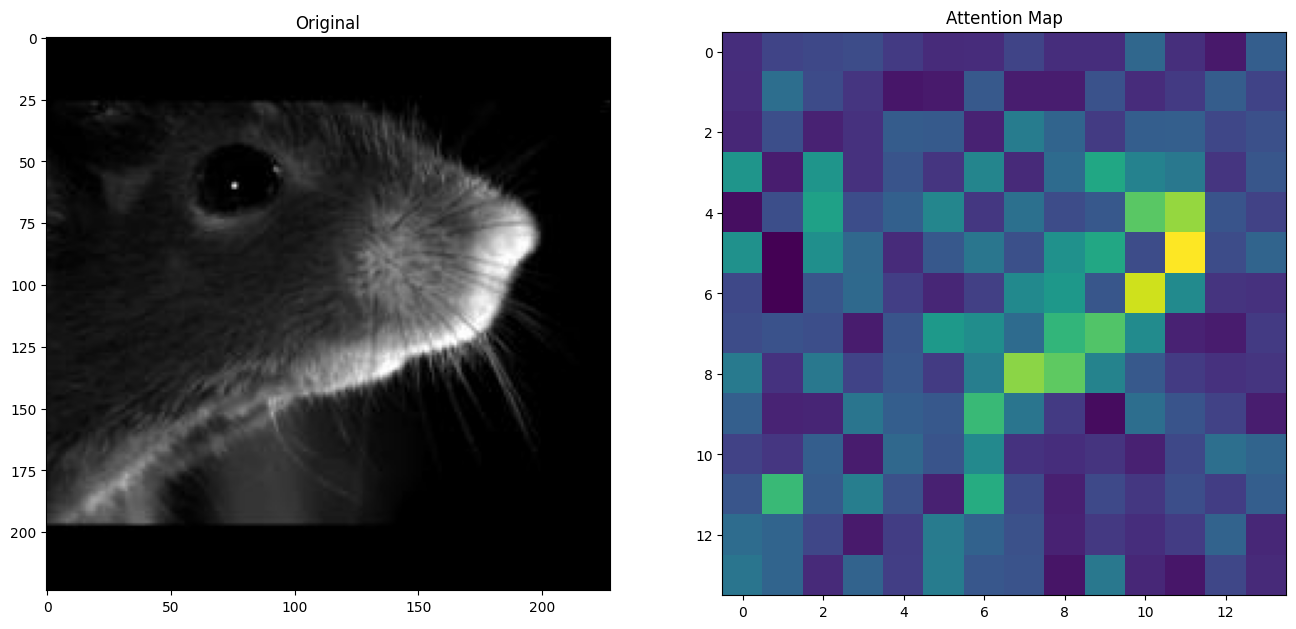

Input tensor size: torch.Size([1, 197, 768])


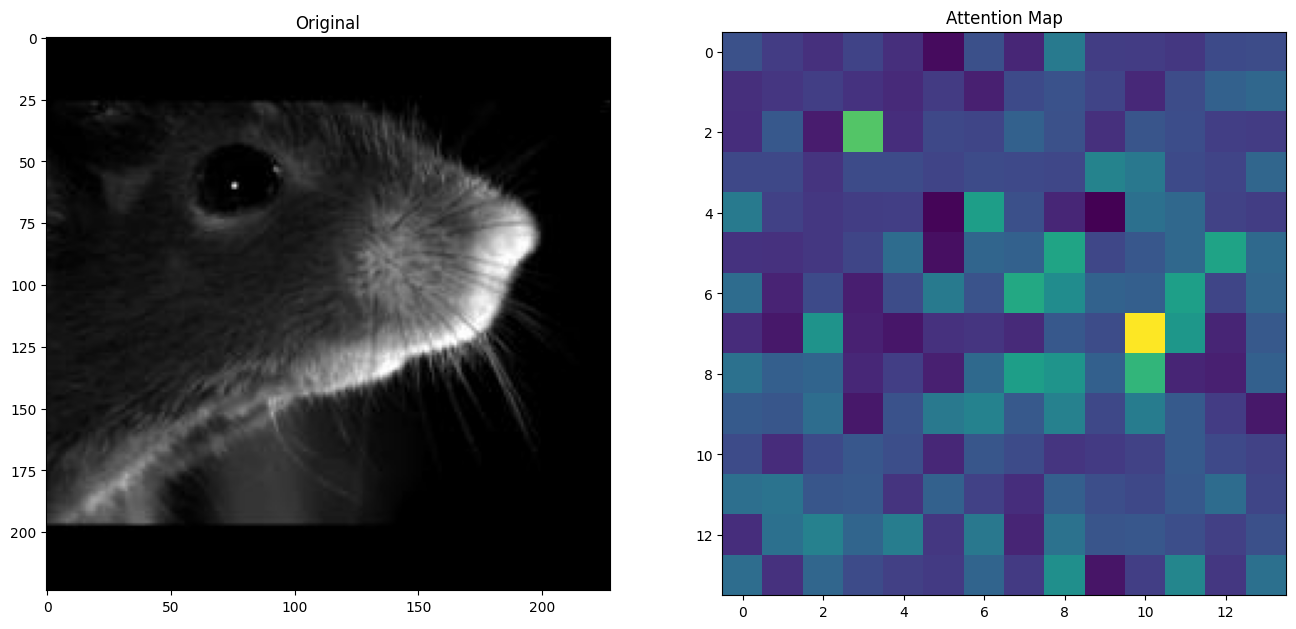

Input tensor size: torch.Size([1, 197, 768])


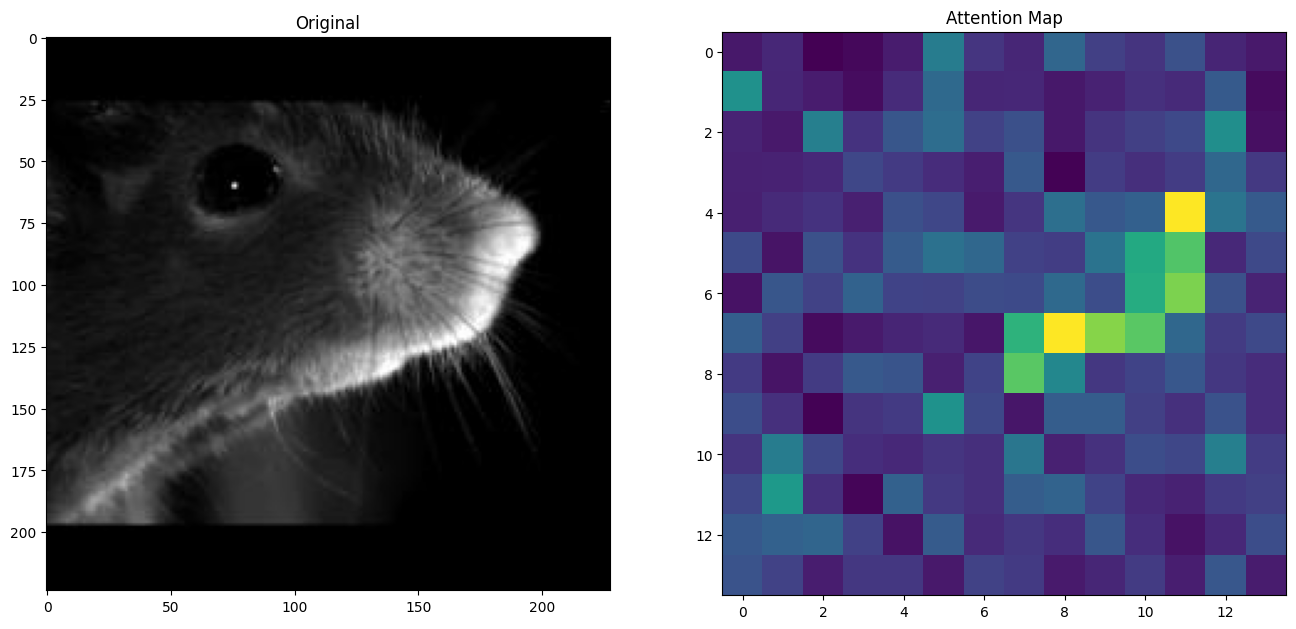

Input tensor size: torch.Size([1, 197, 768])


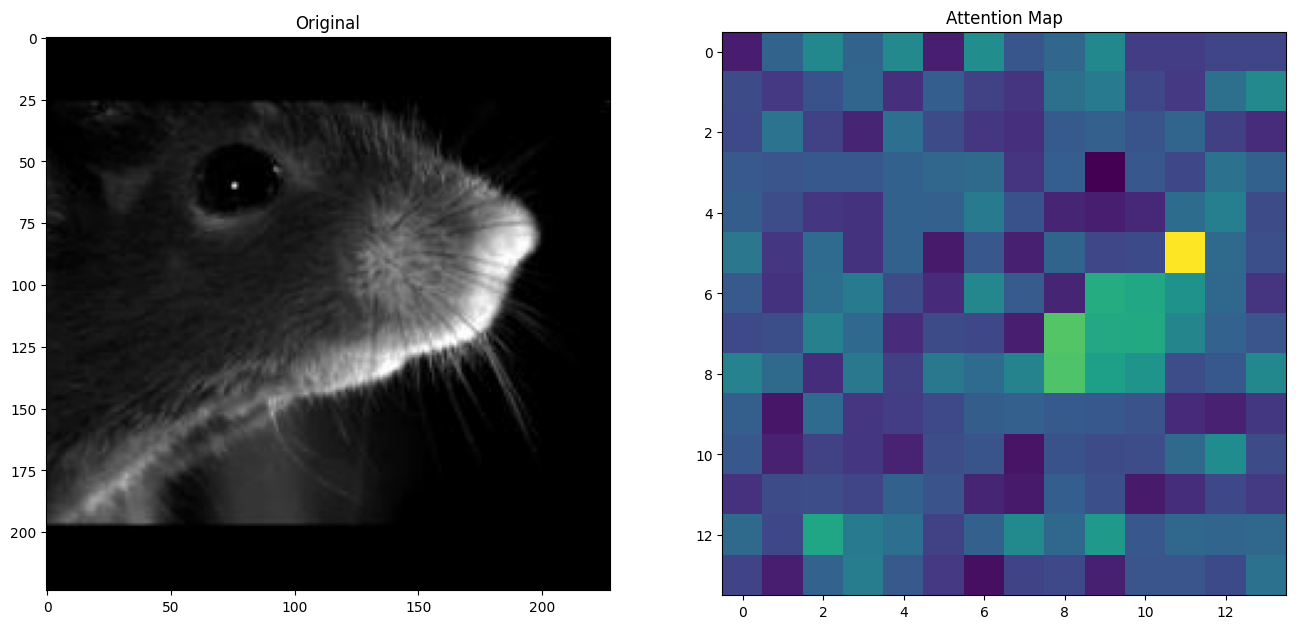

In [ ]:
# Display the original image and attention map
for i in range(24):
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.0)
    mask = grad_rollout(x.unsqueeze(0), category_index=i)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')

    # Display the original image
    ax1.imshow(image)

    # Display the attention map as a heatmap
    ax2.imshow(mask)
    #cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
    #fig.colorbar(cax, ax=ax2, orientation='vertical')

    plt.show()


#result = (mask * im).astype("uint8")
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
#ax1.set_title('Original')
#ax2.set_title('Attention Map_%d Layer' % (i+1))
#_ = ax1.imshow(im)
#_ = ax2.imshow(im)
#cax = ax2.imshow(mask, alpha=.7, cmap = 'viridis')
#fig.colorbar(cax, ax=ax2, orientation='vertical')

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


AttributeError: 'VisionTransformer' object has no attribute 'blocks'

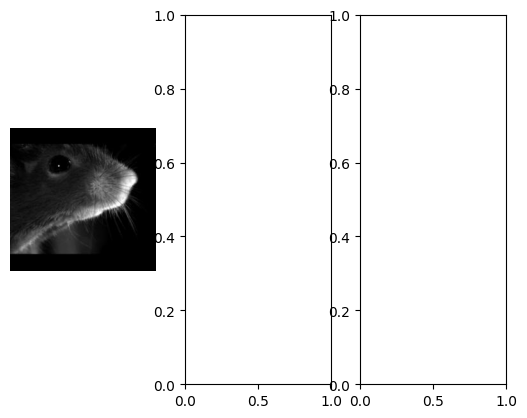

In [ ]:
#image = Image.open('samples/catdog.png')
#dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(x.unsqueeze(0))
#print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(x)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(x, class_index=0)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

In [ ]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Input tensor size: torch.Size([1, 197, 768])
tensor([[[[9.2404e-01, 6.2079e-04, 5.3646e-04,  ..., 4.8016e-04,
           5.1420e-04, 5.9551e-04],
          [9.5549e-01, 3.7273e-04, 3.4380e-04,  ..., 2.7144e-04,
           2.8310e-04, 3.0910e-04],
          [9.5448e-01, 3.5945e-04, 3.6691e-04,  ..., 2.9468e-04,
           3.0194e-04, 3.0359e-04],
          ...,
          [9.4991e-01, 2.7363e-04, 2.8508e-04,  ..., 4.4283e-04,
           4.5083e-04, 4.4779e-04],
          [9.5051e-01, 2.7476e-04, 2.8169e-04,  ..., 4.2938e-04,
           4.6011e-04, 4.6728e-04],
          [9.5007e-01, 2.8579e-04, 2.7001e-04,  ..., 4.0810e-04,
           4.4668e-04, 4.8984e-04]],

         [[9.8137e-01, 1.0263e-04, 9.8734e-05,  ..., 8.7593e-05,
           8.7050e-05, 8.8003e-05],
          [1.2524e-01, 6.0954e-03, 7.0725e-03,  ..., 6.3608e-03,
           6.4603e-03, 5.3950e-03],
          [1.2626e-01, 6.5687e-03, 6.6658e-03,  ..., 6.0285e-03,
           6.1393e-03, 5.8240e-03],
          ...,
          [1.4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming att_mat is obtained from your model
logits, att_mat = model(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Input tensor size: torch.Size([1, 197, 768])
tensor([[[[9.2404e-01, 6.2079e-04, 5.3646e-04,  ..., 4.8016e-04,
           5.1420e-04, 5.9551e-04],
          [9.5549e-01, 3.7273e-04, 3.4380e-04,  ..., 2.7144e-04,
           2.8310e-04, 3.0910e-04],
          [9.5448e-01, 3.5945e-04, 3.6691e-04,  ..., 2.9468e-04,
           3.0194e-04, 3.0359e-04],
          ...,
          [9.4991e-01, 2.7363e-04, 2.8508e-04,  ..., 4.4283e-04,
           4.5083e-04, 4.4779e-04],
          [9.5051e-01, 2.7476e-04, 2.8169e-04,  ..., 4.2938e-04,
           4.6011e-04, 4.6728e-04],
          [9.5007e-01, 2.8579e-04, 2.7001e-04,  ..., 4.0810e-04,
           4.4668e-04, 4.8984e-04]],

         [[9.8137e-01, 1.0263e-04, 9.8734e-05,  ..., 8.7593e-05,
           8.7050e-05, 8.8003e-05],
          [1.2524e-01, 6.0954e-03, 7.0725e-03,  ..., 6.3608e-03,
           6.4603e-03, 5.3950e-03],
          [1.2626e-01, 6.5687e-03, 6.6658e-03,  ..., 6.0285e-03,
           6.1393e-03, 5.8240e-03],
          ...,
          [1.4

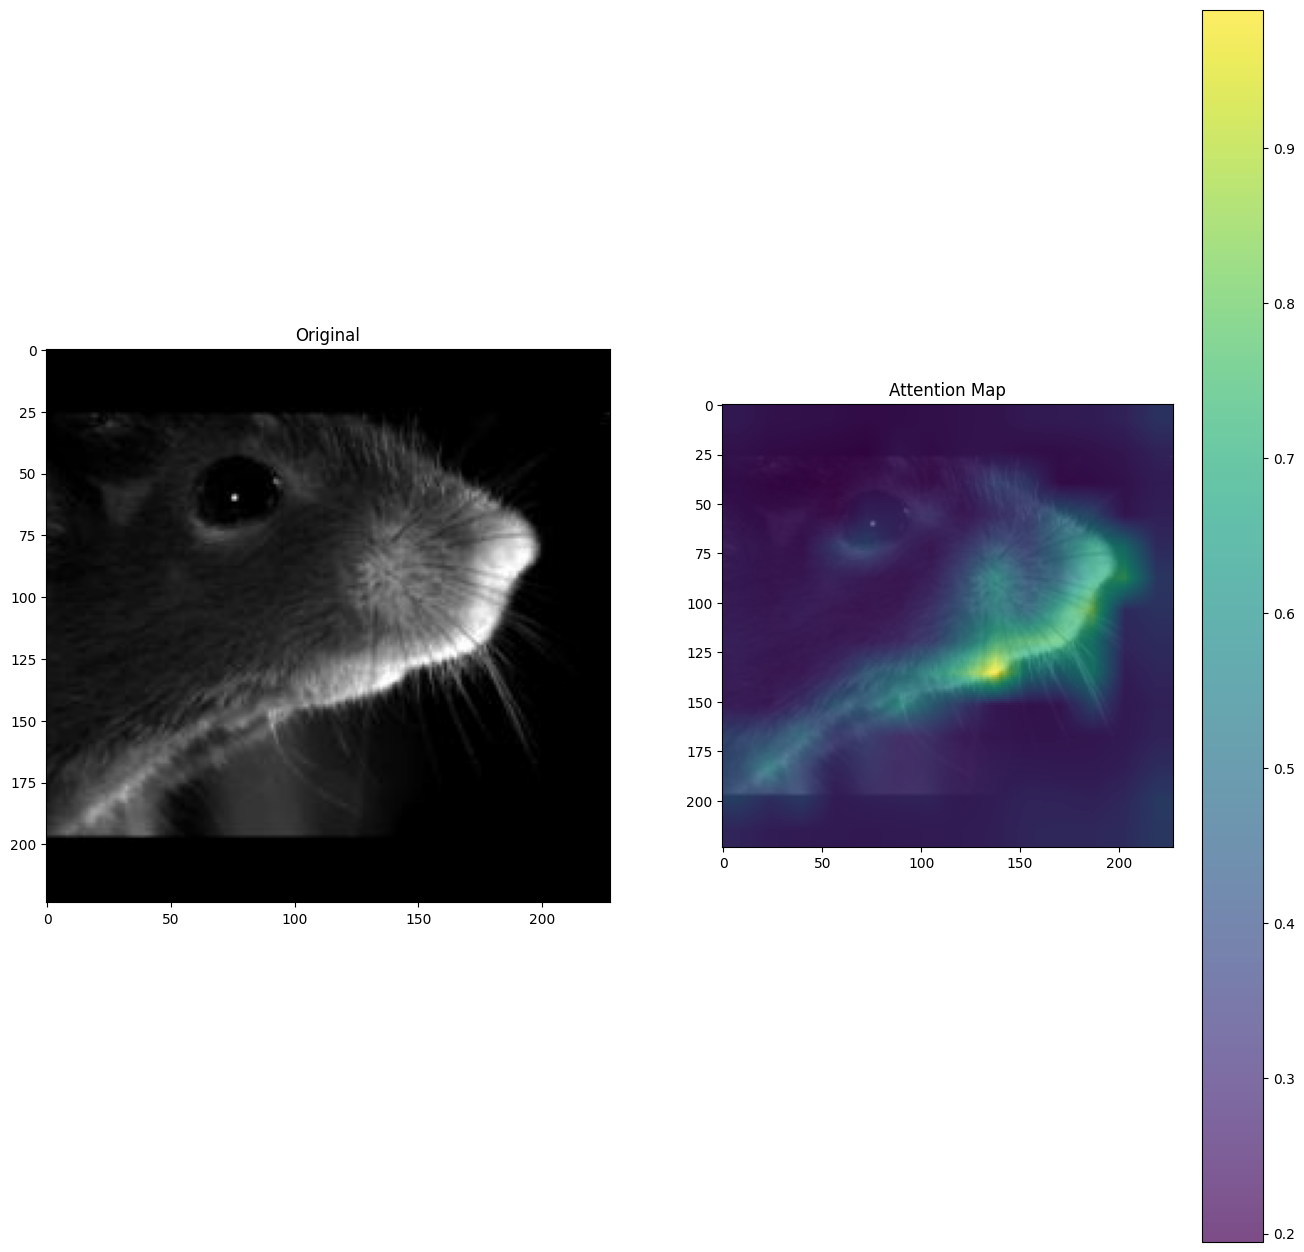

In [ ]:
# Display the original image and attention map
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')

# Display the original image
ax1.imshow(im)

# Display the attention map as a heatmap
ax2.imshow(im)
cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
fig.colorbar(cax, ax=ax2, orientation='vertical')

plt.show()

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

Input tensor size: torch.Size([1, 197, 768])
tensor([[[[9.2404e-01, 6.2079e-04, 5.3646e-04,  ..., 4.8016e-04,
           5.1420e-04, 5.9551e-04],
          [9.5549e-01, 3.7273e-04, 3.4380e-04,  ..., 2.7144e-04,
           2.8310e-04, 3.0910e-04],
          [9.5448e-01, 3.5945e-04, 3.6691e-04,  ..., 2.9468e-04,
           3.0194e-04, 3.0359e-04],
          ...,
          [9.4991e-01, 2.7363e-04, 2.8508e-04,  ..., 4.4283e-04,
           4.5083e-04, 4.4779e-04],
          [9.5051e-01, 2.7476e-04, 2.8169e-04,  ..., 4.2938e-04,
           4.6011e-04, 4.6728e-04],
          [9.5007e-01, 2.8579e-04, 2.7001e-04,  ..., 4.0810e-04,
           4.4668e-04, 4.8984e-04]],

         [[9.8137e-01, 1.0263e-04, 9.8734e-05,  ..., 8.7593e-05,
           8.7050e-05, 8.8003e-05],
          [1.2524e-01, 6.0954e-03, 7.0725e-03,  ..., 6.3608e-03,
           6.4603e-03, 5.3950e-03],
          [1.2626e-01, 6.5687e-03, 6.6658e-03,  ..., 6.0285e-03,
           6.1393e-03, 5.8240e-03],
          ...,
          [1.4

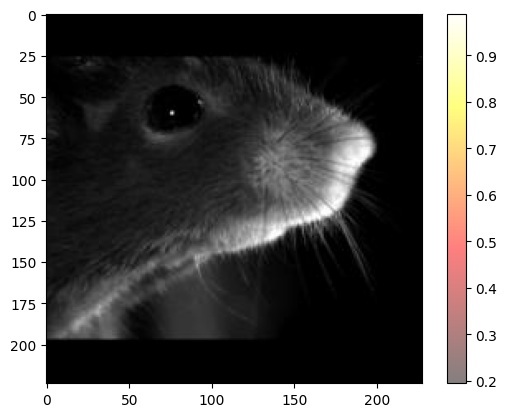

In [ ]:
# Assuming att_mat is obtained from your model
#logits, att_mat = model(x.unsqueeze(0)) # logits kunne vaere predictions, hvor kommer 197 fra?
logits, att_mat = model.forward(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)

# Create a heatmap using 'hot' colormap
heatmap = plt.imshow(mask, cmap='hot', interpolation='nearest')

# Apply alpha channel to the heatmap
heatmap.set_alpha(0.5)

# Display the original image
plt.imshow(im)

# Show the colorbar
plt.colorbar(heatmap)

plt.show()

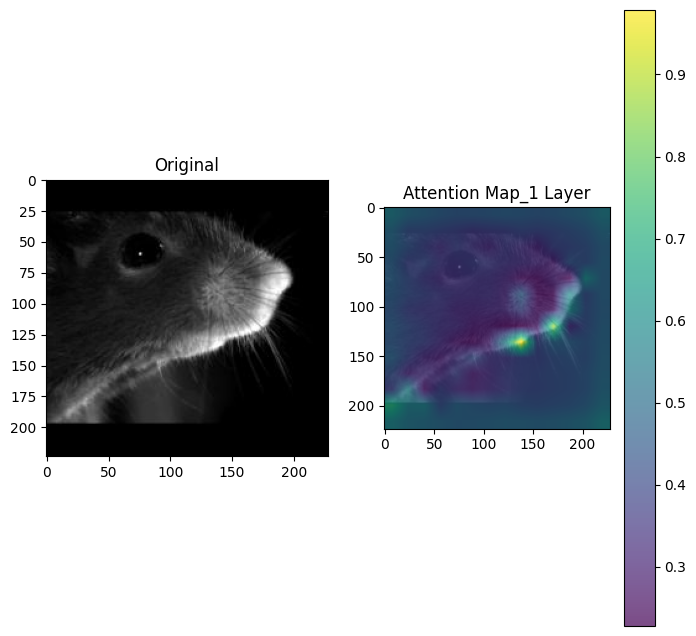

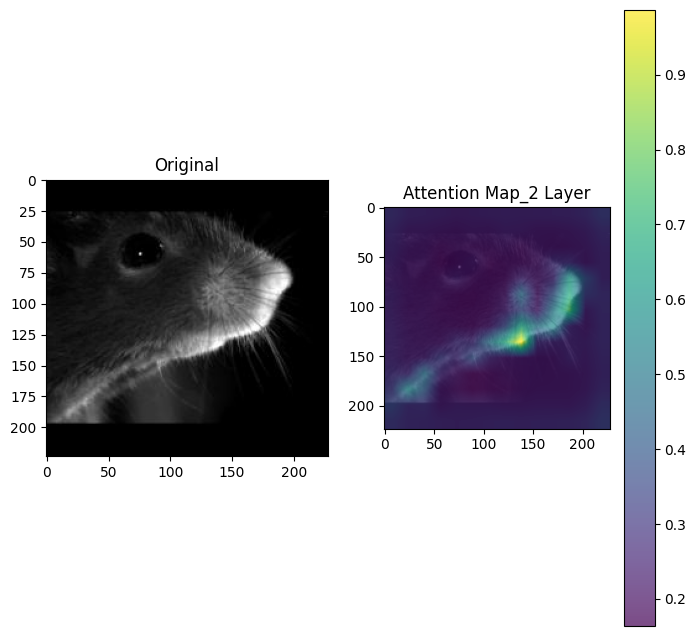

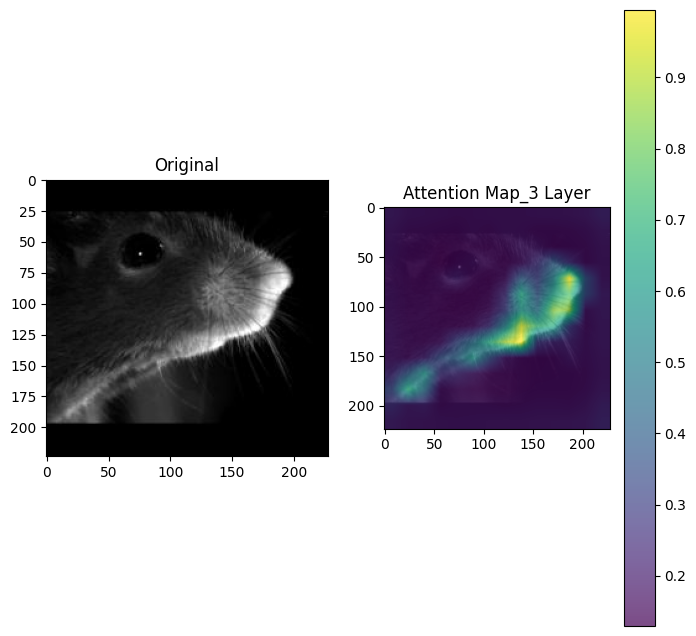

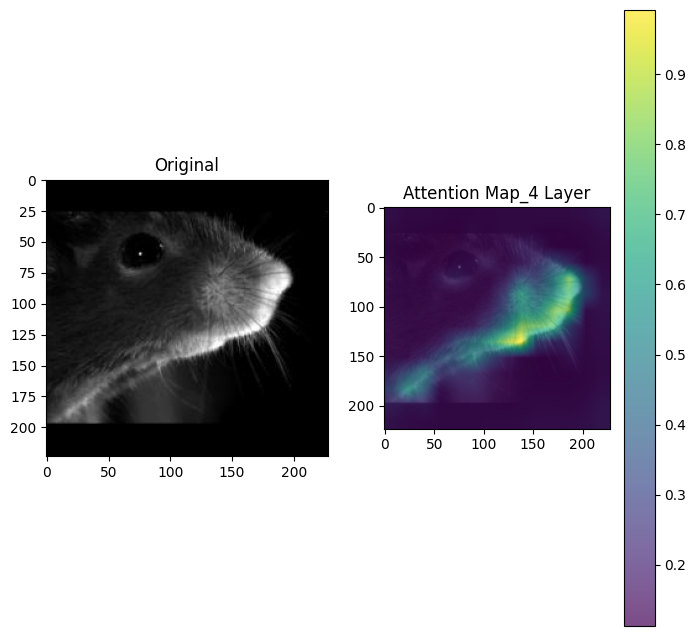

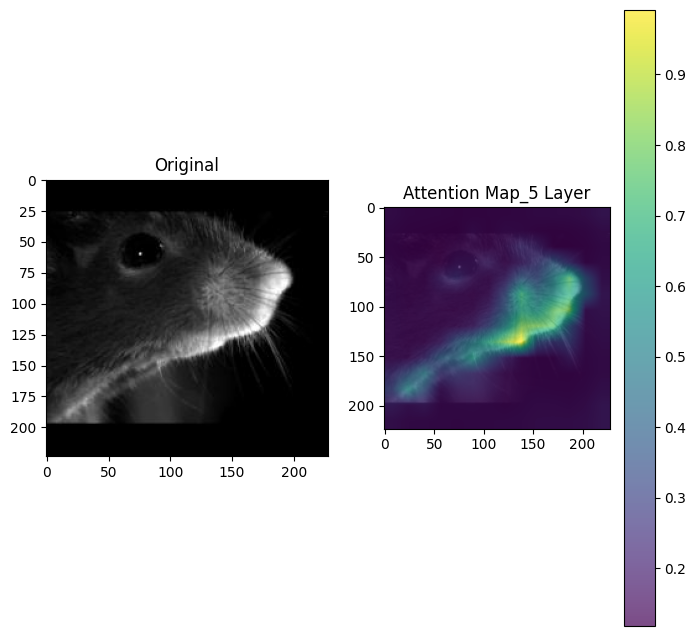

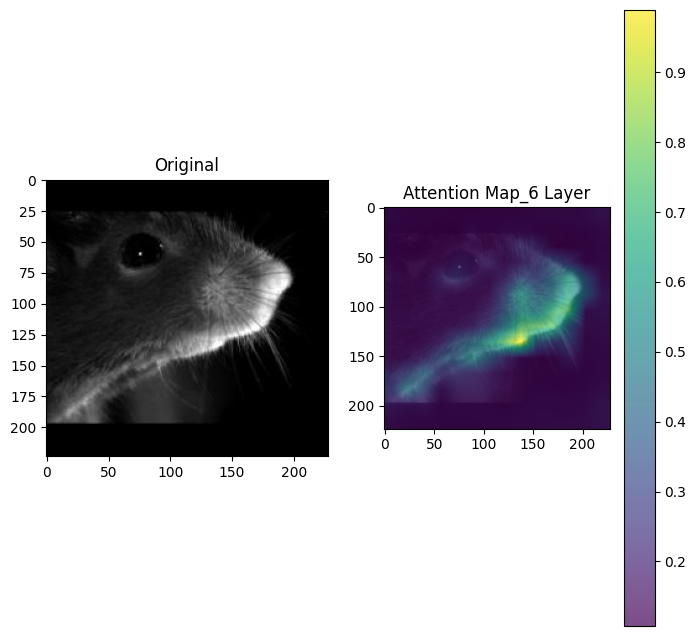

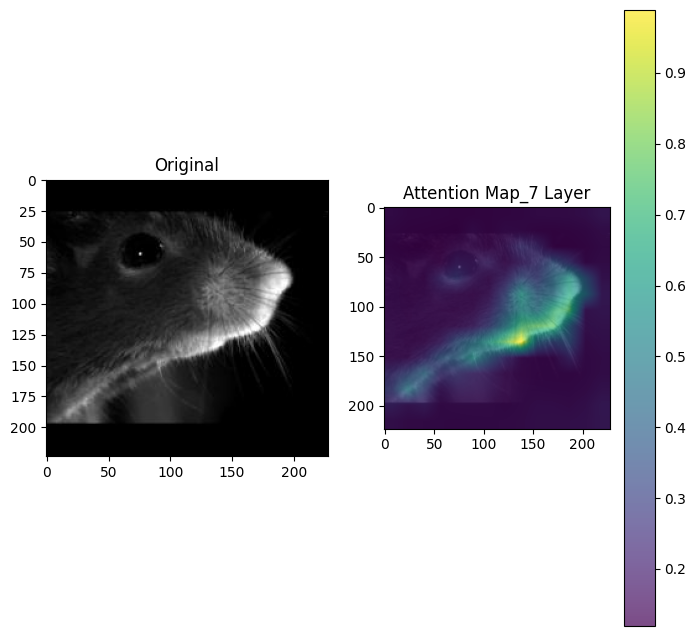

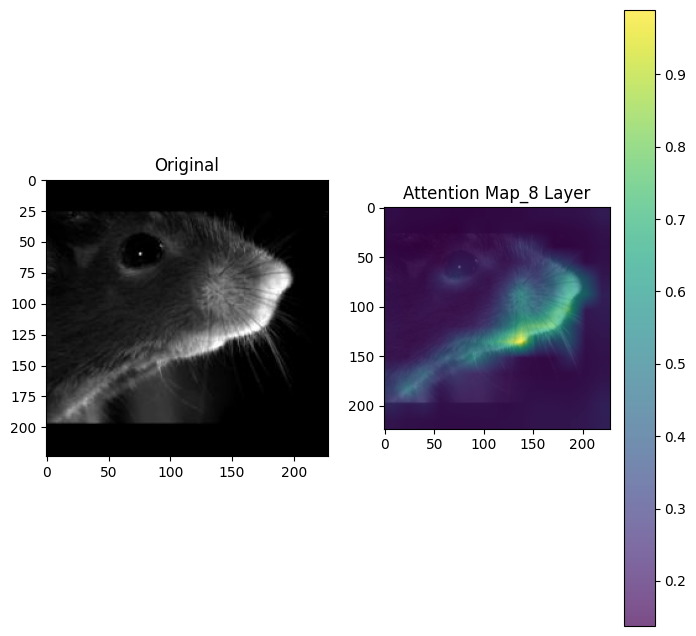

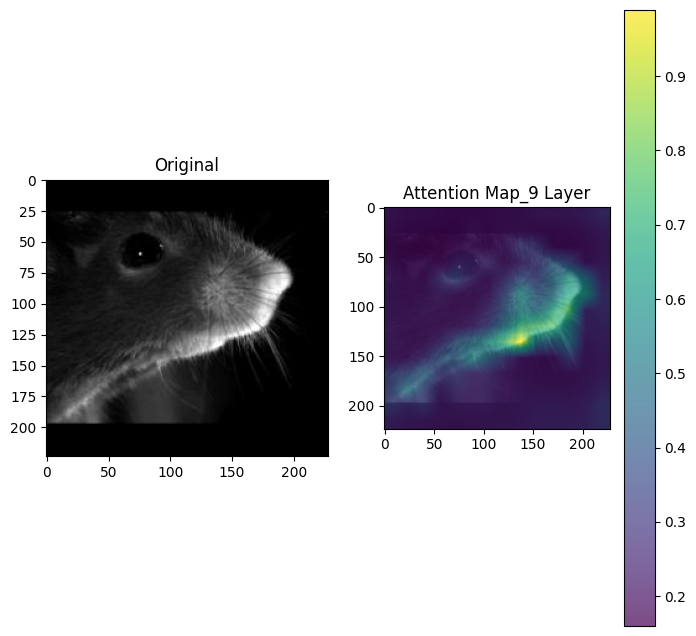

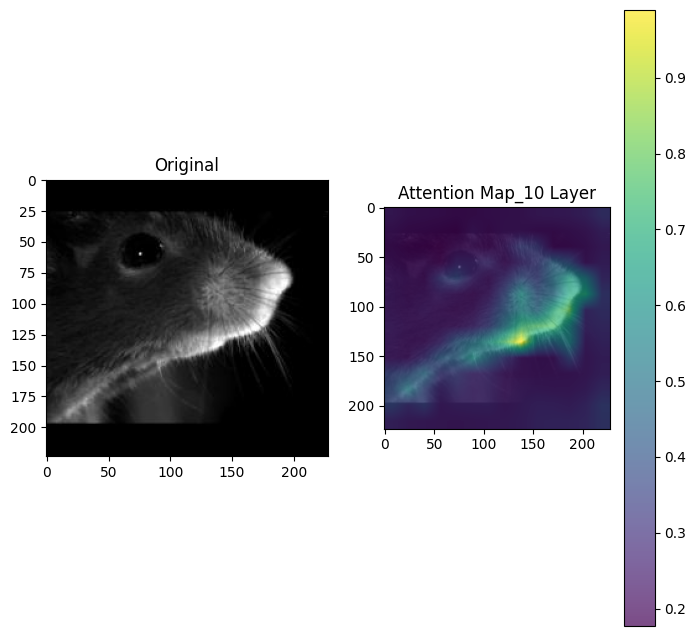

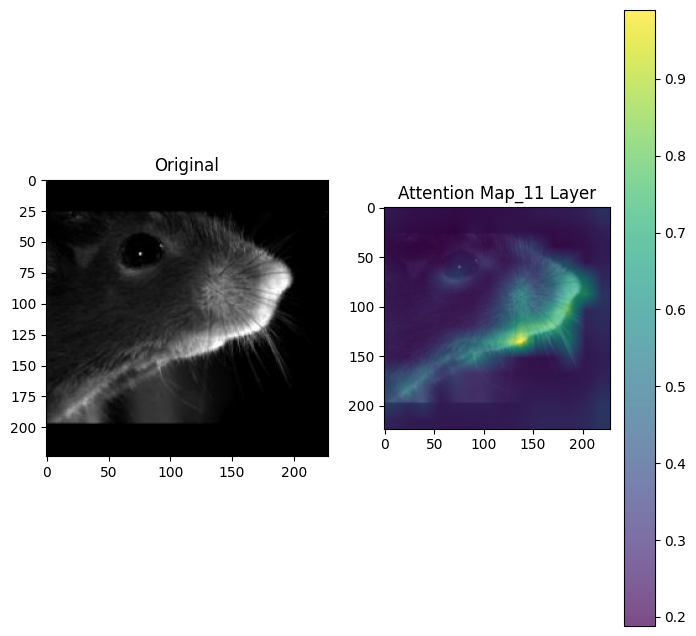

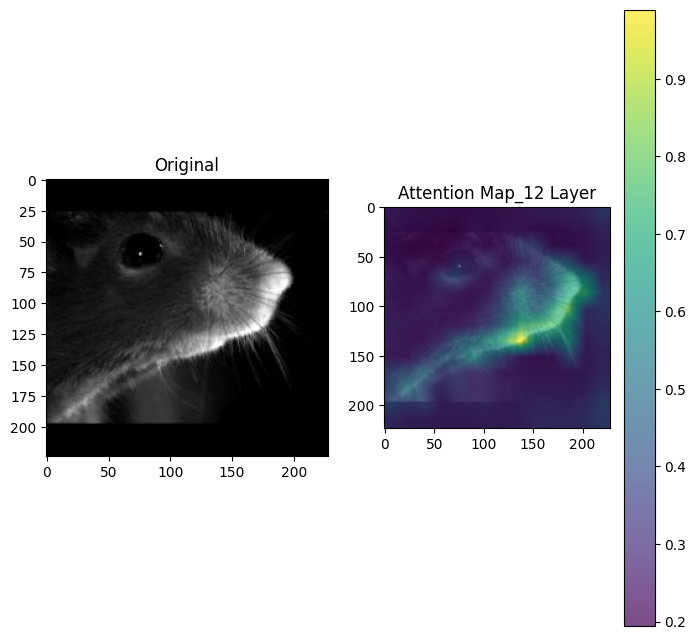

In [ ]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(im)
    cax = ax2.imshow(mask, alpha=.7, cmap = 'viridis')
    fig.colorbar(cax, ax=ax2, orientation='vertical')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


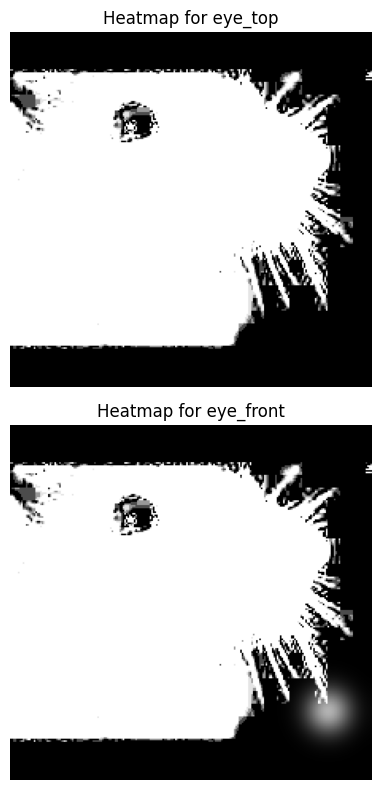

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to calculate attention map for a key point
def calculate_attention_map(keypoint_data, image_shape):
    # Generate a blank image with the same shape as the original image
    attention_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    # Extract key point coordinates
    x, y = keypoint_data
    
    # Set the attention value at the key point location
    attention_map[y, x] = 1.0  # You might need to adjust the indexing based on the format of your key point data
    
    # Apply Gaussian blur to smoothen the attention map
    attention_map = gaussian_filter(attention_map, sigma=10)  # Adjust the sigma value as needed
    
    # Normalize attention map to [0, 1]
    attention_map = attention_map / np.max(attention_map)
    
    return attention_map

# Function to overlay attention map on original image with transparency
def overlay_attention_map(image, attention_map, alpha=0.7):
    # Convert attention map to 3-channel image
    attention_map = np.expand_dims(attention_map, axis=2)
    attention_map = np.tile(attention_map, (1, 1, 3))
    
    # Apply transparency to attention map
    overlay = image.copy()
    overlay = cv2.addWeighted(overlay.astype(np.float32), 1 - alpha, attention_map, alpha, 0)
    
    return overlay

# Load original image
original_image = cv2.imread("augmented_data_test/img8504_flip_rescale_augmented.jpg")  # Replace "original_image.jpg" with the path to your original image

# Define the coordinates of each key point
keypoints = {
    "eye_top": (100, 150),
    "eye_front": (200, 180),
    # Add more key points as needed
}

# Plot attention maps for each key point
plt.figure(figsize=(10, 8))
for idx, (key, keypoint_data) in enumerate(keypoints.items(), 1):
    # Calculate attention map for the current key point
    attention_map = calculate_attention_map(keypoint_data, original_image.shape)
    
    # Overlay attention map on original image
    overlaid_image = overlay_attention_map(original_image, attention_map)
    
    # Plot the overlaid image
    plt.subplot(2, len(keypoints)//2, idx)
    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Heatmap for {key}")
    plt.axis("off")

plt.tight_layout()
plt.show()